Paris case study

In this notebook, we focus **exclusively on Paris Airbnb listings**. We apply, compare, and interpret the core methods covered in the course:
1. **Exploratory analysis and Dimensionality reduction:** PCA (course content) and UMAP (extra method).
2. **Baseline classification models:** LDA and CART (Decision Trees).
3. **Ensemble methods:** Bootstrap, Bagging, and Random Forest.

In [3]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore') # keep the notebook clean without red alerts

# 2. Manipulation des données
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from sklearn.utils import resample

from sklearn.decomposition import PCA
import umap.umap_ as umap # 'umap-learn' and not 'umap'

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

Data loading and train/test split

In [4]:
DATA_PATH = "data/paris_dataset_final_ready.csv.gz" 

df_paris = pd.read_csv(DATA_PATH, compression='gzip', low_memory=False)
print(f"{df_paris.shape[1]} columns.\n")

y = df_paris['target_class']
cols_to_drop = ['target_class', 'price_clean', 'city_label']
X = df_paris.drop(columns=[col for col in cols_to_drop if col in df_paris.columns])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=123
)   # stratify to preserve class distribution in both train and test sets

print(f"\nFeatures (X) : {X.shape[1]} columns")
print(f"Target (y) : {len(y)} values")
print(f"\nClass distribution:")
print(y.value_counts().sort_index())
print(f"Train dimensions: X={X_train.shape}, y={y_train.shape}")
print(f"Test dimensions:  X={X_test.shape}, y={y_test.shape}\n")

# STANDARDIZATION
# Trees will use X_train to stay interpretable 
# PCA and UMAP will use X_train_scaled
scaler = StandardScaler()

X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)

30 columns.


Features (X) : 27 columns
Target (y) : 73111 values

Class distribution:
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64
Train dimensions: X=(58488, 27), y=(58488,)
Test dimensions:  X=(14623, 27), y=(14623,)



# PCA: Principal Component Analysis

### Removing redundancy in PCA and UMAP: motivations

rt_* and pg_* both describe the listing type (entire unit vs private room vs etc.). Thus, they encode the same information. Keeping both is like repeating the same feature twice.

We keep a single encoding of listing type to avoid double-counting the same information. This produces cleaner PCA/UMAP embeddings and more interpretable, more stable downstream models.


It harms PCA/UMAP interpretation:

- PCA: duplicated signals can dominate the first components and make PC1 “listing type” twice instead of revealing other structure (distance, size, amenities scores…).
- UMAP (distance-based): duplicated binary features can double-count that information, pulling points together/apart mainly because of repeated listing-type encoding.


It can hurt modeling (make it unstable): even if performance doesn’t crash, interpretation becomes messy. Removing redundancy gives cleaner embeddings (PCA/UMAP), more stable models, and a clearer interpretation not to duplicated categorical encoding.

In [6]:
X_redundancy = df_paris.drop(columns=["target_class", "price_clean", "city_label"], errors="ignore").copy()

rt_cols = [c for c in X_redundancy.columns if c.startswith("rt_")]
pg_cols = [c for c in X_redundancy.columns if c.startswith("pg_")]

corr = pd.DataFrame(index=rt_cols, columns=pg_cols)
for r in rt_cols:
    for p in pg_cols:
        corr.loc[r, p] = X_redundancy[r].corr(X_redundancy[p])

corr = corr.astype(float)
corr

pg_entire_unit  pg_hotel  pg_private_room
rt_Entire home/apt        0.991545 -0.493997        -0.825274
rt_Private room          -0.927514  0.346177         0.882248
rt_Shared room           -0.156780  0.010979        -0.012236

It shows that these variables are strongly correlated (close to 1)

## Case A: Standardizing everything 

We standardize everything, including 0/1 variables. It corresponds roughly to doing PCA on a correlation matrix (each variable gets comparable scale).

Scaling 0/1 variables to unit variance can make them very influential, especially if the feature is rare (very imbalanced 0/1) or if there exists several correlated binaries (rt_* and pg_* encode similar info).

It answers the question: “what variables matter equally?”.

In [10]:
warnings.filterwarnings('ignore')

#configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)


print(f" dataset loaded: {df_paris.shape}")
print(f"\n columns overview:")
print(df_paris.columns.tolist())

#check target
if 'target_class' in df_paris.columns:
    print(f"\n target found: {df_paris['target_class'].nunique()} classes")
    print(df_paris['target_class'].value_counts().sort_index())
else:
    print(" warning: 'target_class' not found in dataset")

#overview
print(f"\n first 5 rows:")
print(df_paris.head())

#prepare X/y and train/test split

#code
print("=" * 60)
print("preparation: X/y split and train/test split")
print("=" * 60)

#split X (features) and y (target)
y = df_paris['target_class']
X = df_paris.drop(columns=["target_class", "price_clean", "city_label"], errors="ignore").copy()

pg_cols = [c for c in X.columns if c.startswith("pg_")] # Drop redundant family: pg_*
X = X.drop(columns=pg_cols)

print("Dropped pg_* columns:", pg_cols)
print("New X shape:", X.shape)

#remove city_label if present
if 'city_label' in X.columns:
    X = X.drop(columns=['city_label'])

print(f"\nfeatures (X): {X.shape[1]} columns")
print(f"target (y): {len(y)} values")
print(f"\ndistribution of classes:")
print(y.value_counts().sort_index())

#stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"\n split done:")
print(f"  train: {X_train.shape}")
print(f"  test : {X_test.shape}")
print(f"\ndistribution train:")
print(y_train.value_counts().sort_index())
print(f"\ndistribution test:")
print(y_test.value_counts().sort_index())

print([c for c in X.columns if c.startswith("rt_")])
print([c for c in X.columns if c.startswith("pg_")]) #should be empty after drop

 dataset loaded: (73111, 30)

 columns overview:
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']

 target found: 4 classes
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64

 first 5 rows:
   accommodates  bedrooms  beds  minimum_nights_avg_ntm  number_of_reviews  \
0             2       1.0   0.0                     2.0                  4   
1             1       1.0   1.0                    30.0                 42   
2             2       0.0   1.0                     1.0                403   
3    


PCA results
components for 90% variance: 17/24
components for 95% variance: 19/24
possible reduction: 20.8%


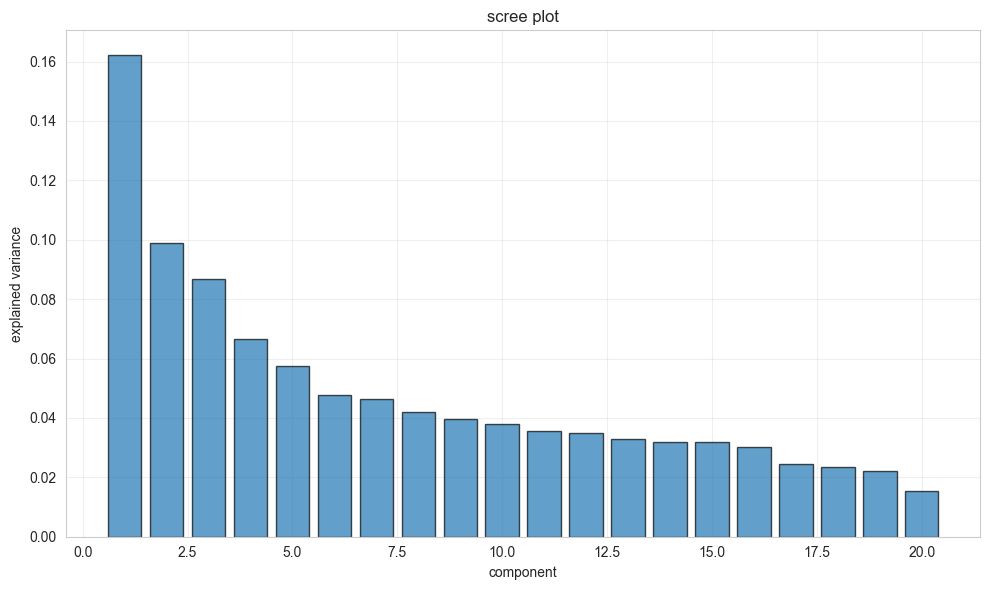

In [12]:
#standardization
scaler_pca = StandardScaler()
X_train_std = scaler_pca.fit_transform(X_train)
X_test_std = scaler_pca.transform(X_test)

#pca
pca_full = PCA()
pca_full.fit(X_train_std)

#explained variance
var_exp = pca_full.explained_variance_ratio_
var_cum = np.cumsum(var_exp)

#number of components
n_comp_95 = np.argmax(var_cum >= 0.95) + 1
n_comp_90 = np.argmax(var_cum >= 0.90) + 1

print(f"\nPCA results")
print(f"components for 90% variance: {n_comp_90}/{X.shape[1]}")
print(f"components for 95% variance: {n_comp_95}/{X.shape[1]}")
print(f"possible reduction: {(1 - n_comp_95/X.shape[1])*100:.1f}%")

#screeplot
plt.figure(figsize=(10, 6))
plt.bar(range(1, min(21, len(var_exp)+1)), var_exp[:20], alpha=0.7, edgecolor='black')
plt.title("scree plot")
plt.xlabel("component")
plt.ylabel("explained variance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


This scree plot displays the explained variance for the first 20 components of the PCA performed on the standardized Paris dataset. 

PC1 explains 16.2% and PC2 explains 9.9% Then, it gradually decreases (no huge “elbow”). Our data has no single dominant factor: variance is spread across many features (normal for mixed “size + amenities + scores + location + binaries”).

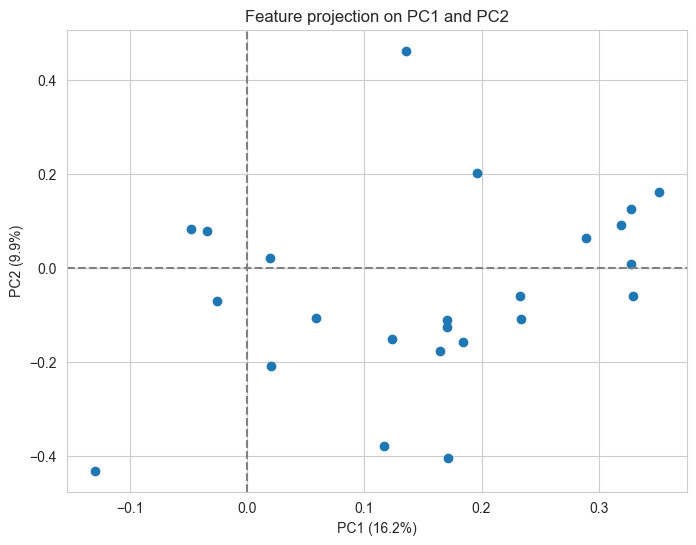

In [13]:
#plot features projection on PC1 and PC2 axes
plt.figure(figsize=(8,6))
plt.scatter(pca_full.components_[0], pca_full.components_[1])
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
pc1_pct = pca_full.explained_variance_ratio_[0]*100
pc2_pct = pca_full.explained_variance_ratio_[1]*100
plt.xlabel(f'PC1 ({pc1_pct:.1f}%)')
plt.ylabel(f'PC2 ({pc2_pct:.1f}%)')
plt.title('Feature projection on PC1 and PC2')
plt.show()

We are plotting each feature by its loading on:
- x = loading on PC1
- y = loading on PC2

How to interpret it? 
- Points far from (0,0) = features that matter a lot for PC1/PC2.
- Same direction = positively correlated structure in this 2D PC space.
- Opposite direction = trade-off / negative relationship.

PC1 is mainly “size + amenities quality” (accommodates, bedrooms, beds, bathrooms_qty) + “equipment / quality (has_dishwasher, has_washing_machine) + engineered scores (score_chef_kitchen, score_coffee, score_wellness)

--> PC1 = “bigger + better-equipped listings”.

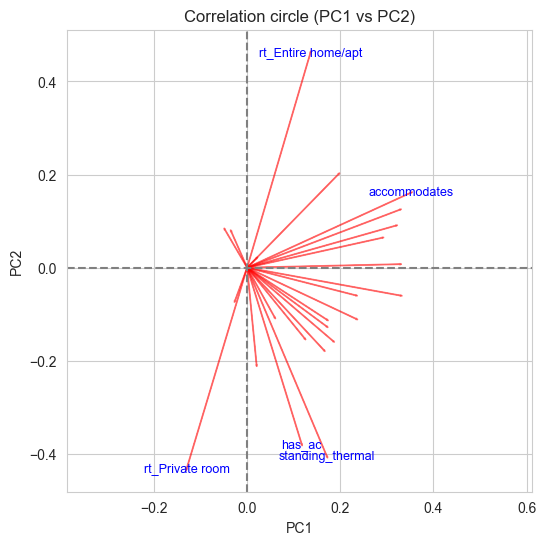

In [14]:
#correlation circle for PC1 and PC2 
plt.figure(figsize=(6,6))
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.gca().add_artist(plt.Circle((0,0), 1, color='b', fill=False))
vecs = pca_full.components_[:2]
corrs = np.linalg.norm(vecs, axis=0)
top_idx = np.argsort(corrs)[-5:] #top 5 features with highest correlation to PC1/PC2
for i in range(len(X.columns)):
    plt.arrow(0, 0, vecs[0,i], vecs[1,i], color='r', alpha=0.5)
for i in top_idx:
    plt.text(vecs[0,i], vecs[1,i], X.columns[i], fontsize=9, ha='center', va='center', color='blue')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Correlation circle (PC1 vs PC2)')
plt.axis('equal')
plt.show()

How to read it?
- Arrow length (closer to the circle) = feature is well represented by PC1/PC2.
- Angle between arrows: Small angle means positively correlated; Opposite directions means negatively correlated; ~90° means weakly related in this PC1/PC2 view

Interpretation : 
- Accommodates points to the right: strongly linked to PC1 (size factor)
- rt_Entire home/apt points mostly upward: it contributes strongly to PC2
- has_ac and standing_thermal pointing downward suggests they load in the opposite direction of PC2 compared to rt_Entire home/apt

So PC2 is capturing a listing type axis (entire home vs other profile) + some amenities that go in the opposite direction.

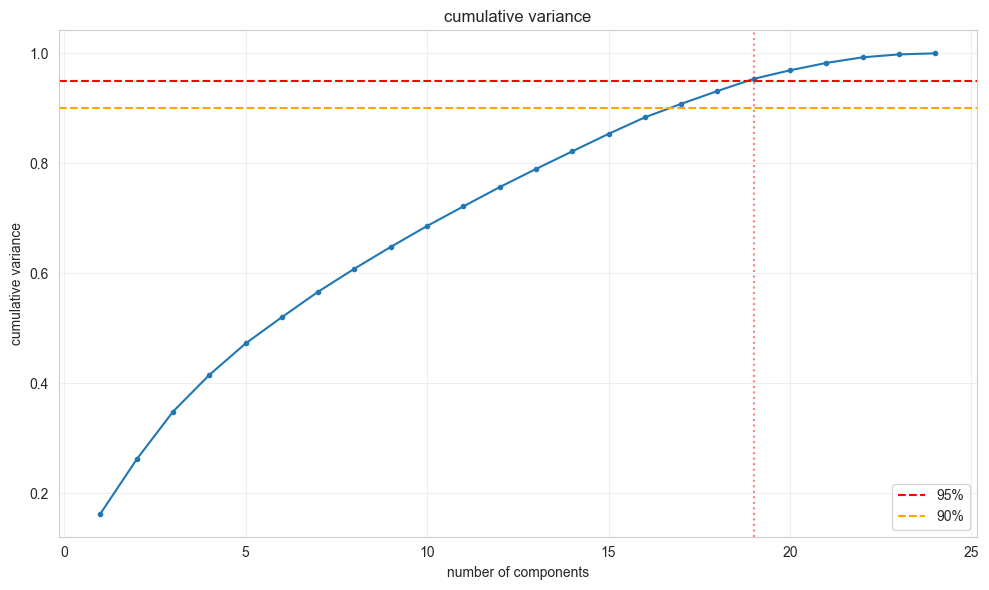

In [15]:
#cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(var_cum)+1), var_cum, marker='o', markersize=3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90%')
plt.axvline(x=n_comp_95, color='r', linestyle=':', alpha=0.5)
plt.title("cumulative variance")
plt.xlabel("number of components")
plt.ylabel("cumulative variance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

90% variance: 17 components out of 24; 95% variance: 19 components out of 24
“Possible reduction” 20.8%

If we want to keep almost all information, PCA doesn’t give a huge reduction (we still need many PCs).

For visualization, using 2 PCs is still fine — but PC1 + PC2 are only 26.1% of total variance.


 top 10 features PC1:
            feature  loading
       accommodates 0.351158
 score_chef_kitchen 0.328893
     has_dishwasher 0.327554
           bedrooms 0.327392
               beds 0.318960
      bathrooms_qty 0.289550
       score_coffee 0.233729
     score_wellness 0.232933
has_washing_machine 0.195849
       has_elevator 0.184317

 top 10 features PC2:
            feature  loading
 rt_Entire home/apt 0.461497
    rt_Private room 0.431766
   standing_thermal 0.404994
             has_ac 0.378702
  number_of_reviews 0.208407
has_washing_machine 0.200484
        has_parking 0.176973
       accommodates 0.160814
       has_elevator 0.157447
         score_view 0.151752


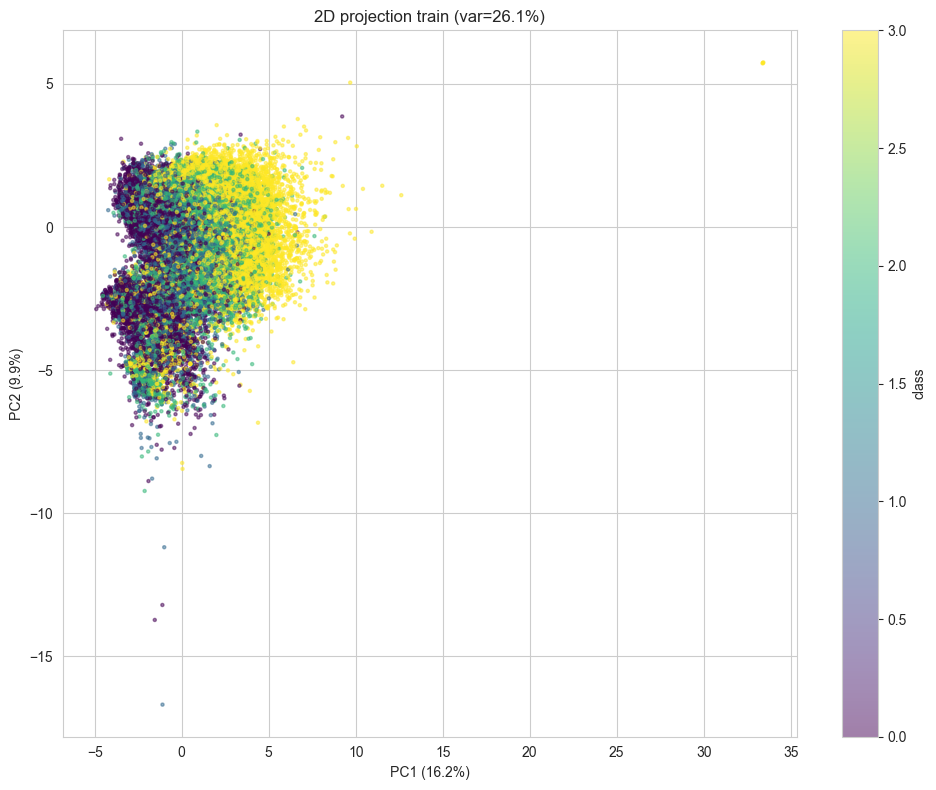

In [17]:
#2D projection
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_std)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], 
                     c=y_train, cmap='viridis', s=5, alpha=0.5)
plt.title(f"2D projection train (var={pca_2d.explained_variance_ratio_.sum():.1%})")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})")
plt.colorbar(scatter, label='class')
plt.tight_layout()

#feature importance PC1
pc1_loadings = pd.DataFrame({
    'feature': X.columns,
    'loading': np.abs(pca_full.components_[0])
}).sort_values('loading', ascending=False)

print(f"\n top 10 features PC1:")
print(pc1_loadings.head(10).to_string(index=False))

#feature importance PC2
pc2_loadings = pd.DataFrame({
    'feature': X.columns,
    'loading': np.abs(pca_full.components_[1])
}).sort_values('loading', ascending=False)

print(f"\n top 10 features PC2:")
print(pc2_loadings.head(10).to_string(index=False))

Clear gradient along PC1: 
- higher classes (more expensive quartiles) tend to sit more to the right
- Classes overlap a lot (expected), because: PC1+PC2 explains only 26% of variance and price quartile is influenced by multiple factors, some nonlinear.

Interpretation:

- PC1 is strongly aligned with price even though we removed price_clean. It's normal: size + amenities quality are real drivers of price.

- The big stretch on the x-axis (up to 35) suggests some strong outliers (extreme standard deviations). That can happen with skewed variables (e.g., reviews, min nights, etc.).

## Case B: Separating scaling 

We should separate scaling whenever we want to see structure driven more by continuous attributes (distance, accommodates, amenities scores…) rather than “room type". 

We will use the same PCA but scaling continuous features and leave binary features as 0/1. This automatically “downweights” binaries a bit (because their variance is ≤ 0.25), and can reveal other structure.

It answers the question. : “what structure exists beyond room type?”.

In [19]:
# y = target
y = df_paris["target_class"].copy()

# X = features (remove target and leakage-like columns)
X = df_paris.drop(columns=["target_class", "price_clean", "city_label"], errors="ignore").copy()

pg_cols = [c for c in X.columns if c.startswith("pg_")] # Drop redundant family: pg_*
X = X.drop(columns=pg_cols)

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())

print([c for c in X.columns if c.startswith("rt_")])
print([c for c in X.columns if c.startswith("pg_")]) #should be empty after drop



#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify binary vs continuous columns:
#    - binary: values are subset of {0,1} (or only {0} or {1})
#    - continuous: everything else
def is_binary_series(s: pd.Series) -> bool:
    vals = pd.Series(s.dropna().unique())     # Drop NA, get unique values
    if len(vals) == 0:
        return False
    try:     # Try to coerce to numeric when possible
        vals = pd.to_numeric(vals)
    except Exception:
        return False
    return set(vals.tolist()).issubset({0, 1})     # Check subset of {0,1}


binary_cols = [c for c in X_train.columns if is_binary_series(X_train[c])]
continuous_cols = [c for c in X_train.columns if c not in binary_cols]

print(f"Detected {len(continuous_cols)} continuous columns:", continuous_cols)
print(f"Detected {len(binary_cols)} binary columns:", binary_cols)

# Scale continuous features (fit on train, transform both) and Keep binary as it is.
scaler = StandardScaler()

X_train_cont_scaled = scaler.fit_transform(X_train[continuous_cols])
X_test_cont_scaled  = scaler.transform(X_test[continuous_cols])

# Convert back to DataFrame for clean concatenation
X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=continuous_cols, index=X_train.index)
X_test_cont_scaled  = pd.DataFrame(X_test_cont_scaled,  columns=continuous_cols, index=X_test.index)

# Binary stays as 0/1 (ensure numeric dtype)
X_train_bin = X_train[binary_cols].astype(float)
X_test_bin  = X_test[binary_cols].astype(float)

# Rebuild final matrices in the same column order as original X
X_train_prepared = pd.concat([X_train_cont_scaled, X_train_bin], axis=1)[X.columns]
X_test_prepared  = pd.concat([X_test_cont_scaled,  X_test_bin],  axis=1)[X.columns]

print("Prepared train shape:", X_train_prepared.shape)
print("Prepared test shape:", X_test_prepared.shape)

X shape: (73111, 24)
y distribution:
 target_class
0    19114
2    18299
3    18249
1    17449
Name: count, dtype: int64
['rt_Entire home/apt', 'rt_Private room', 'rt_Shared room']
[]
Detected 15 continuous columns: ['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'dist_to_center', 'bathrooms_qty', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity']
Detected 9 binary columns: ['has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room']
Prepared train shape: (58488, 24)
Prepared test shape: (14623, 24)



PCA results (scale continuous only)
components for 90% variance: 13/24
components for 95% variance: 16/24
possible reduction: 33.3%


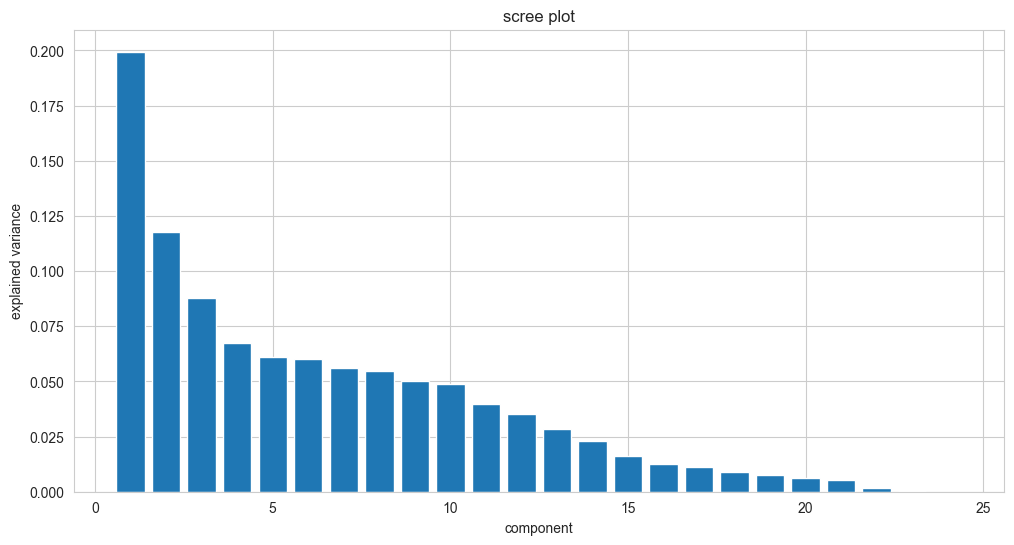

In [21]:
#PCA 
pca_full = PCA()
pca_full.fit(X_train_prepared)

explained_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

n90 = np.argmax(cum_var >= 0.90) + 1
n95 = np.argmax(cum_var >= 0.95) + 1

print("\nPCA results (scale continuous only)")
print(f"components for 90% variance: {n90}/{X.shape[1]}")
print(f"components for 95% variance: {n95}/{X.shape[1]}")
print(f"possible reduction: {(1 - n95 / X.shape[1]) * 100:.1f}%")

# Scree plot
plt.figure()
plt.bar(range(1, len(explained_var) + 1), explained_var)
plt.title("scree plot")
plt.xlabel("component")
plt.ylabel("explained variance")
plt.show()

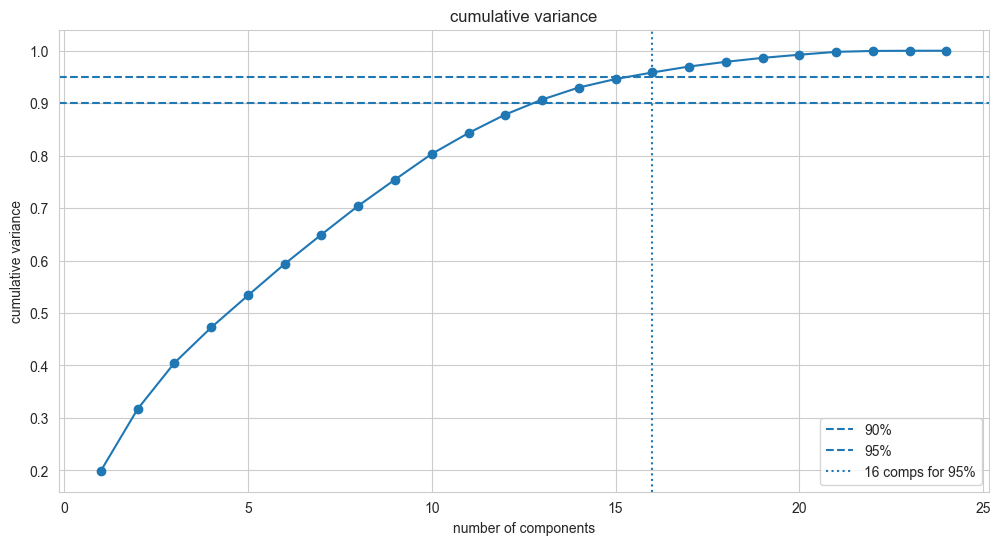

In [22]:

# Cumulative variance plot
plt.figure()
plt.plot(range(1, len(cum_var) + 1), cum_var, marker="o")
plt.axhline(0.90, linestyle="--", label="90%")
plt.axhline(0.95, linestyle="--", label="95%")
plt.axvline(n95, linestyle=":", label=f"{n95} comps for 95%")
plt.title("cumulative variance")
plt.xlabel("number of components")
plt.ylabel("cumulative variance")
plt.legend()
plt.show()

We need fewer components: 
- 90%: 13 vs before 17
- 95%: 16 vs before 19

It is expected. 
- Before, we standardized everything: each variable contributes as 1 unit of variance. So, total variance = number of variables (27). 
- Now, continuous variables still have variance = 1 (because scaled), but binary variables keep their natural variance (≈ p(1−p), often < 0.25, sometimes much smaller if rare). Therefore, binaries contribute less to total variance, and the remaining variance is “more concentrated”, so we hit 90/95% with fewer PCs.

PCA focuses more on the continuous structure (size, distance, scores), and less on “binary noise / redundancy”.


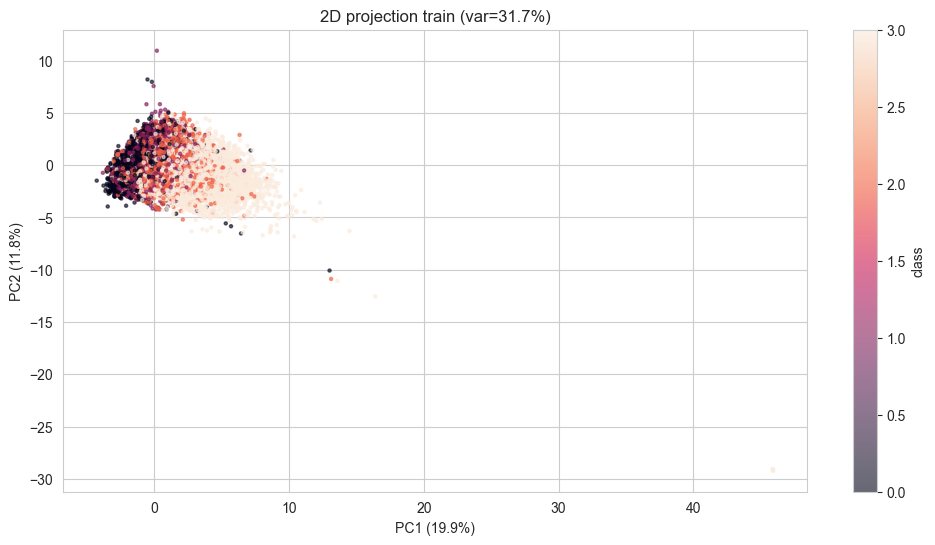

In [23]:

# 2D projection (PC1, PC2) with class color
pca_2d = PCA(n_components=2)
Z_train_2d = pca_2d.fit_transform(X_train_prepared)

plt.figure()
sc = plt.scatter(Z_train_2d[:, 0], Z_train_2d[:, 1], c=y_train, s=5, alpha=0.6)
plt.title(f"2D projection train (var={pca_2d.explained_variance_ratio_.sum()*100:.1f}%)")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)")
plt.colorbar(sc, label="class")
plt.show()


In [24]:
# Top 10 features for PC1
loadings_pc1 = pd.Series(pca_full.components_[0], index=X.columns)
top10_pc1 = loadings_pc1.abs().sort_values(ascending=False).head(10)

print("\nTop 10 features PC1 (abs loading):")
print(pd.DataFrame({"feature": top10_pc1.index, "loading": loadings_pc1[top10_pc1.index].values}))


Top 10 features PC1 (abs loading):
              feature   loading
0        accommodates  0.441852
1            bedrooms  0.428913
2                beds  0.413004
3       bathrooms_qty  0.382686
4  score_chef_kitchen  0.288405
5      score_wellness  0.243983
6        score_coffee  0.211655
7          score_work  0.181870
8    standing_thermal  0.168536
9      has_dishwasher  0.135226


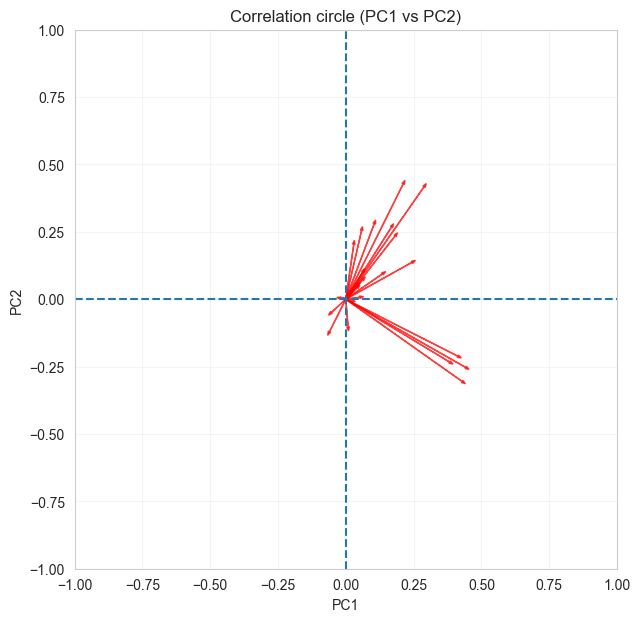

In [25]:
# Correlation circle (PC1 vs PC2)
# Approx correlation circle: use loadings scaled by sqrt(eigenvalues) if you want true correlations,
# but your current approach of plotting components is OK for interpretation consistency.
pc1 = pca_full.components_[0]
pc2 = pca_full.components_[1]

plt.figure(figsize=(7, 7))
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.title("Correlation circle (PC1 vs PC2)")

for i, col in enumerate(X.columns):
    plt.arrow(0, 0, pc1[i], pc2[i], head_width=0.01, alpha=0.7, color="red")
    # Option: label only the strongest arrows to keep it readable
    # if abs(pc1[i]) + abs(pc2[i]) > 0.35:
    #     plt.text(pc1[i]*1.05, pc2[i]*1.05, col, fontsize=9)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True, alpha=0.2)
plt.show()

# UMAP : Uniform Manifold Approximation

We will ask and answer the following questions: 
- What is UMAP?
- Is a train/test separation necessary?
- On which variables shall we focus?
- PCA vs UMAP: what are the differences?

## What is UMAP ?
UMAP is a non-linear dimensionality reduction method designed to preserve structure of a dataset viewed as lying on a manifold. UMAP’s practical aim is producing an embedding useful for visualization (competitive with t‑SNE but often faster and more scalable).

It is an appropriate exploratory tool here because it can reveal non-linear local structure (listing “archetypes” and neighborhood relationships). UMAP is best interpreted as neighborhood structure (who is closed to whom) not as interpretable axes or exact inter-cluster distances.
It is most reliable for statements about local neighborhoods. If two points are close in the UMAP embedding, they should look close in the original feature space.

UMAP is not reliable for axis or distance interpretations: 
- Axes are not interpretable because UMAP coordinates are not tied to linear combinations of original
features and can rotate without changing the solution quality.
- Distances between separated clusters can be visually meaningful, but should not be treated as
precise “how far apart segments are” in the original high-dimensional space

### The importance of the parameters : 
- n_neighbors (local vs global trade-off): it controls neighborhood size used to approximate the manifold. Smaller values emphasize local structure; larger values promote more global coherence.
- min_dist (how “clumpy” clusters appear): Sets the minimum distance between points in the low-dimensional embedding; smaller values allow tighter packing and visually “clumpier” embeddings; larger values spread points out.
- metric: it defines how distances are computed in the original space (can whange whether it is a binary or continuous space)


In [27]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

These are all our variables. As it will be presented later, we will use UMAP on several variables to obtain different visualization of our dataset, depending on the price, the location...

Separation of the features X and the target Y. UMAP is a unsupervised machhine learning method – such as t-SNE or PCA –, so we need to supress any link between features and target variables.

In [32]:
# Target
y = df_paris["target_class"].copy()

# Features
X = df_paris.drop(columns=["target_class", "price_clean", "city_label"], errors="ignore").copy()

# Drop redundant family: pg_*
pg_cols = [c for c in X.columns if c.startswith("pg_")]
X = X.drop(columns=pg_cols)

print("X shape:", X.shape)
print("rt_*:", [c for c in X.columns if c.startswith("rt_")])
print("pg_* (should be empty):", [c for c in X.columns if c.startswith("pg_")])
print("y distribution:\n", y.value_counts().sort_index())

X shape: (73111, 24)
rt_*: ['rt_Entire home/apt', 'rt_Private room', 'rt_Shared room']
pg_* (should be empty): []
y distribution:
 target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64


## Train/test split ? 

#### Case A: UMAP for exploratory visualization only

If UMAP is only used to understand structure, we can either :
- Compute it on the full dataset (or a sample of it):
- color by target or metadata
an then interpret neighborhoods qualitatively. In this case, train/test split is optional; its main value is in checking whether the same structures appear across subsets (stability). The important rule is still to avoid leakage variables if you we are interpreting with respect to the target.


#### Case B: UMAP as a transformer inside an ML pipeline

To train a classifier/regressor on top of UMAP coordinates, we must “fit on train only” to avoid leakage.
We split first and preprocessing it on train only. Then, we transform test (e.g., scaler fit on train) and it UMAP on transformed train only
- Use reducer.transform(X_test_transformed) to embed the test set.
- Train the downstream model on the train embedding and evaluate on the test embedding.

This avoids contaminating evaluation with information that would not exist at prediction time (a core
scikit-learn “common pitfalls” warning).



## Scaling ?

As in PCA, we separate the cases where we scale all variables and where we only scale continuous variables.

We introduce a function that will allow us to scale everything.

In [33]:
def prepare_scale_all(X_train_df, X_test_df=None):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    if X_test_df is None:
        return X_train_scaled, scaler
    X_test_scaled = scaler.transform(X_test_df)
    return (X_train_scaled, X_test_scaled, scaler)

Same but for scaling continuous only

In [34]:
def is_binary_series(s: pd.Series) -> bool:
    vals = pd.Series(s.dropna().unique())
    if len(vals) == 0:
        return False
    try:
        vals = pd.to_numeric(vals)
    except Exception:
        return False
    return set(vals.tolist()).issubset({0, 1})

def prepare_scale_cont_only(X_train_df, X_test_df=None):
    binary_cols = [c for c in X_train_df.columns if is_binary_series(X_train_df[c])]
    cont_cols = [c for c in X_train_df.columns if c not in binary_cols]

    scaler = StandardScaler()
    X_train_cont = pd.DataFrame(
        scaler.fit_transform(X_train_df[cont_cols]),
        columns=cont_cols, index=X_train_df.index
    )
    X_train_bin = X_train_df[binary_cols].astype(float)
    X_train_prepared = pd.concat([X_train_cont, X_train_bin], axis=1)[X_train_df.columns].values

    if X_test_df is None:
        return X_train_prepared, scaler, cont_cols, binary_cols

    X_test_cont = pd.DataFrame(
        scaler.transform(X_test_df[cont_cols]),
        columns=cont_cols, index=X_test_df.index
    )
    X_test_bin = X_test_df[binary_cols].astype(float)
    X_test_prepared = pd.concat([X_test_cont, X_test_bin], axis=1)[X_test_df.columns].values

    return X_train_prepared, X_test_prepared, scaler, cont_cols, binary_cols

### UMAP with train/test split


For methods based on distances (like UMAP), it's crucial to standardize the features to ensure that all features contribute equally to the distance calculations. Otherwise, features with larger scales could dominate (via the variance) the distance metrics, leading to skewed results.

We also limit to 10k samples for UMAP to avoid long computation times and memory issues, while still capturing the overall structure of the data.

#### Scaling all variables

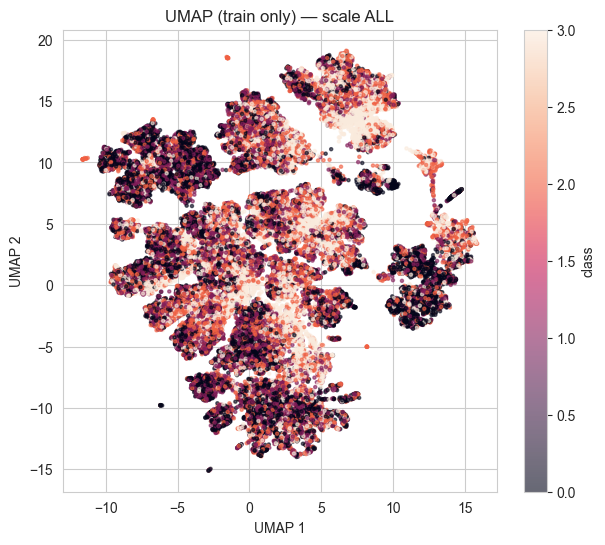

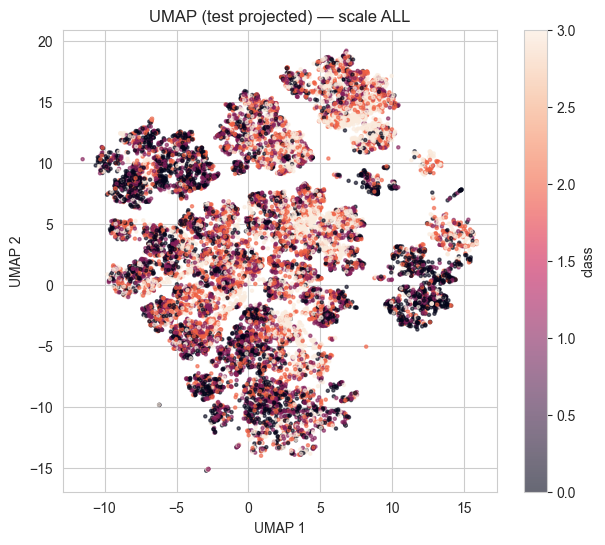

train emb shape: (58488, 2)  test emb shape: (14623, 2)


In [35]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale ALL (fit on train only)
X_train_scaled, X_test_scaled, scaler = prepare_scale_all(X_train, X_test)

# Fit UMAP on train, transform test
reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, n_components=2, random_state=42)
emb_train = reducer.fit_transform(X_train_scaled)
emb_test  = reducer.transform(X_test_scaled)

# Plot train
plt.figure(figsize=(7,6))
sc = plt.scatter(emb_train[:,0], emb_train[:,1], c=y_train, s=5, alpha=0.6)
plt.title("UMAP (train only) — scale ALL")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.colorbar(sc, label="class")
plt.show()

# Plot test (same embedding space)
plt.figure(figsize=(7,6))
sc = plt.scatter(emb_test[:,0], emb_test[:,1], c=y_test, s=5, alpha=0.6)
plt.title("UMAP (test projected) — scale ALL")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.colorbar(sc, label="class")
plt.show()

print("train emb shape:", emb_train.shape, " test emb shape:", emb_test.shape)

#### 2) Scaling only continuous

Continuous: ['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'dist_to_center', 'bathrooms_qty', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity']
Binary: ['has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room']


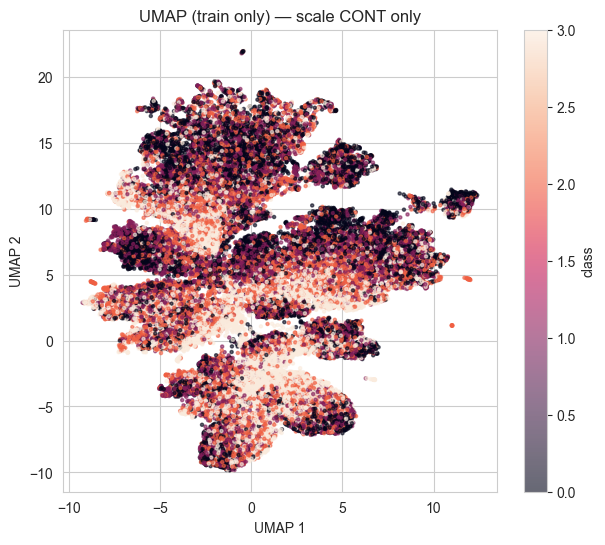

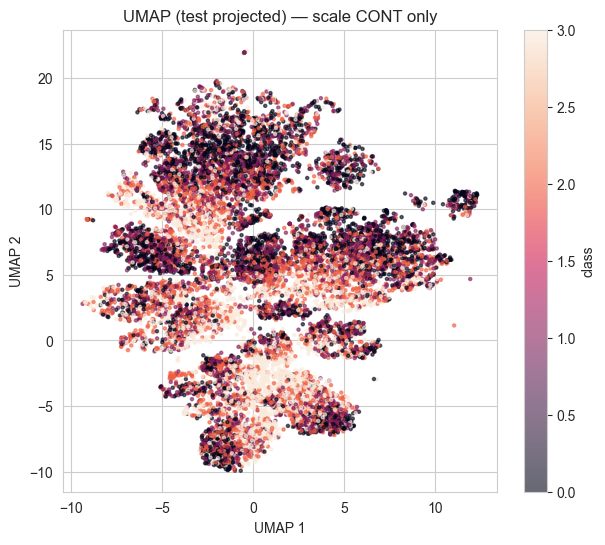

train emb shape: (58488, 2)  test emb shape: (14623, 2)


In [36]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale continuous only (fit on train only)
X_train_prepared, X_test_prepared, scaler, cont_cols, bin_cols = prepare_scale_cont_only(X_train, X_test)

print("Continuous:", cont_cols)
print("Binary:", bin_cols)

# Fit UMAP on train, transform test
reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, n_components=2, random_state=42)
emb_train = reducer.fit_transform(X_train_prepared)
emb_test  = reducer.transform(X_test_prepared)

# Plot train
plt.figure(figsize=(7,6))
sc = plt.scatter(emb_train[:,0], emb_train[:,1], c=y_train, s=5, alpha=0.6)
plt.title("UMAP (train only) — scale CONT only")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.colorbar(sc, label="class")
plt.show()

# Plot test (same embedding space)
plt.figure(figsize=(7,6))
sc = plt.scatter(emb_test[:,0], emb_test[:,1], c=y_test, s=5, alpha=0.6)
plt.title("UMAP (test projected) — scale CONT only")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.colorbar(sc, label="class")
plt.show()

print("train emb shape:", emb_train.shape, " test emb shape:", emb_test.shape)

### UMAP without train/test split

#### 1) Scale all

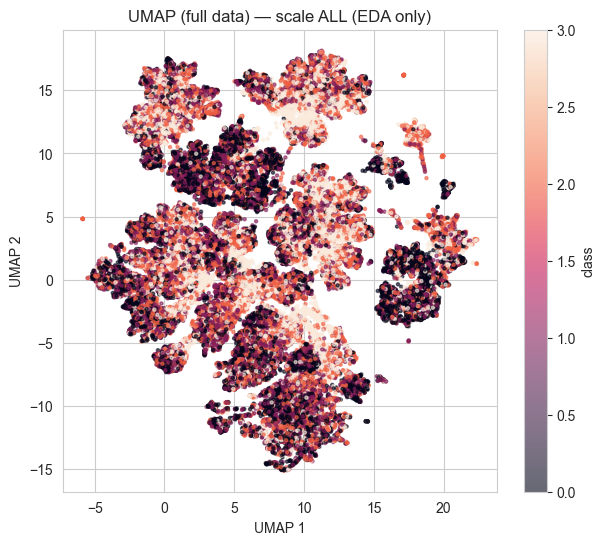

emb shape: (73111, 2)


In [37]:
# Scale ALL on full data (EDA only)
X_all_scaled, scaler = prepare_scale_all(X)

# Fit UMAP on full data
reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, n_components=2, random_state=42)
emb_all = reducer.fit_transform(X_all_scaled)

plt.figure(figsize=(7,6))
sc = plt.scatter(emb_all[:,0], emb_all[:,1], c=y, s=5, alpha=0.6)
plt.title("UMAP (full data) — scale ALL (EDA only)")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.colorbar(sc, label="class")
plt.show()

print("emb shape:", emb_all.shape)

#### 2) Scale continuous only

Continuous: ['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'dist_to_center', 'bathrooms_qty', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity']
Binary: ['has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room']


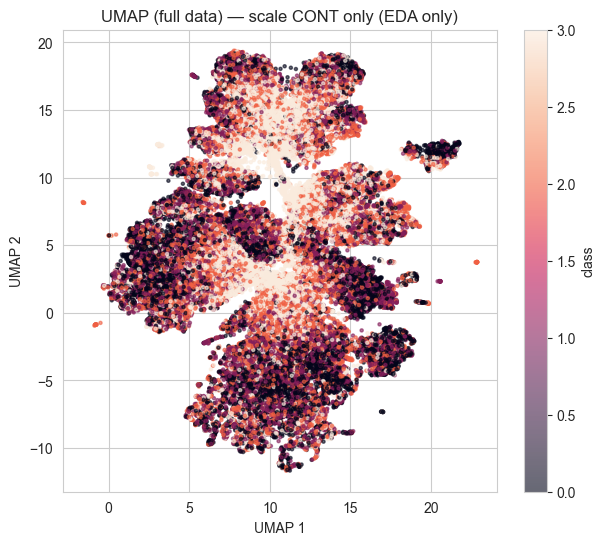

emb shape: (73111, 2)


In [38]:
# Scale continuous only on full data (EDA only)
X_all_prepared, scaler, cont_cols, bin_cols = prepare_scale_cont_only(X)

print("Continuous:", cont_cols)
print("Binary:", bin_cols)

# Fit UMAP on full data
reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, n_components=2, random_state=42)
emb_all = reducer.fit_transform(X_all_prepared)

plt.figure(figsize=(7,6))
sc = plt.scatter(emb_all[:,0], emb_all[:,1], c=y, s=5, alpha=0.6)
plt.title("UMAP (full data) — scale CONT only (EDA only)")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.colorbar(sc, label="class")
plt.show()

print("emb shape:", emb_all.shape)

## What is the added value of UMAP compared to PCA?

PCA: linear projection --> components are interpretable “PC1 is driven by these variables" and
quantifiable “PC1+PC2 explain X% variance.”

UMAP : non-linear and neighborhood-driven --> not an “explained variance” curve

UMAP’s advantage is local structure discovery: 

Here, in this tabular, we have a mixed of continuous and binary variables. The relationships between variables can be non-linear (e.g. room type × capacity × amenities × location). UMAP can reveal non-linear grouping patterns when similarity is not well-modeled by linear directions (such as here in this specific tabular).  

A nonlinear method can reveal sub-populations (“islands”) that PCA sometimes spreads out into elongated shapes, because PCA does not “bend” the space: it only projects it. 

Therefore, it is better to use PCA to interpret the main linear factors and explain the overall structure and use UMAP to visualize local nonlinear patterns, identify archetypes/outliers, and check whether the price classes seem to overlap strongly or not.



## On which feature can we do UMAP? 

The key principle is to choose subsets that support an interpretive question and we shall recall that UMAP is sensitive to the distance metric.

- Full explanatory set as a recommended baseline: UMAP is mainly used as an unsupervised method. So, we include all variables without distinguishing target/features.
- Location and market proxies: dist_to_center, neigh_popularity, number_of_reviews, minimum_nights_avg_ntm --> Focuses on spatial/market dynamics; often yields gradients rather than discrete clusters
- Capacity & configuration: accommodates, bedrooms, beds, bathrooms_qty --> Tests whether listing “size” alone
forms clear archetypes and how it relates to target_class.


LDA

Accuracy: 48.61%
Confusion matrix: 
[[2421  918  407   77]
 [1121 1197  911  261]
 [ 580  788 1441  851]
 [ 334  362  905 2049]]


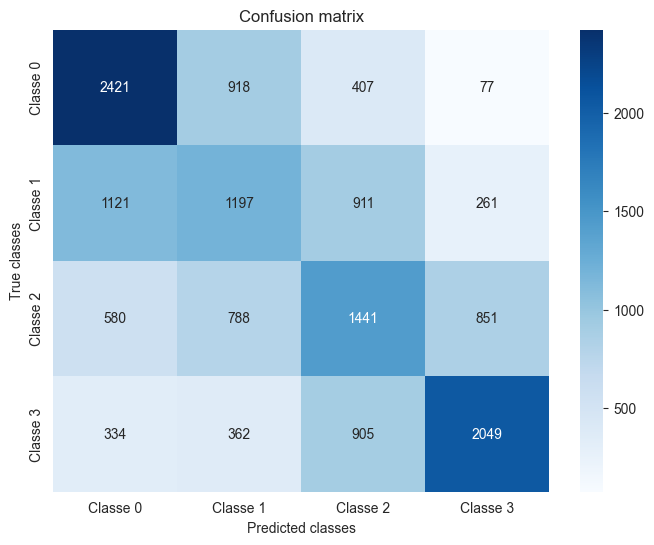

In [ ]:
#LDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#test set predicted classes
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

#accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix: \n{cm}")

#visualization 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Classe {i}' for i in range(4)],
            yticklabels=[f'Classe {i}' for i in range(4)])
plt.title('Confusion matrix')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()


This matrix shows that the data is already able to spot extremes, even if the middle ground is still a bit confusionary. The model can easily identify the cheapest apartments (Class 0: 2421 correct) and the most expensive ones (Class 3: 2049 correct) because of their distinct features. There is a significant overlap between Classes 1 and 2.


LDA Method
Reduced dimensions: 27 → 3
Explained variance: [0.90665568 0.08597618 0.00736814]


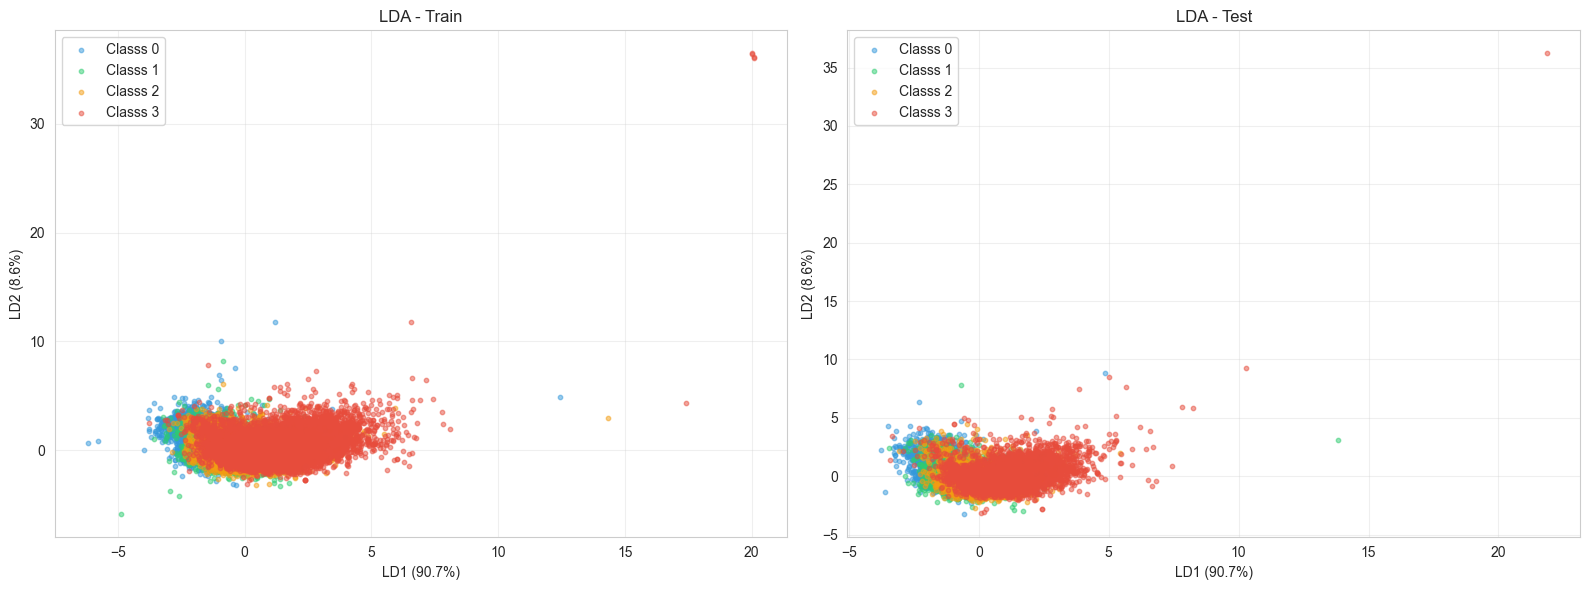

In [ ]:
#LDA
colors_class = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

print("\n" + "=" * 60)
print("LDA Method")
print("=" * 60)

lda = LinearDiscriminantAnalysis(n_components=3) #3 composantes pour 4 classes
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

print(f"Reduced dimensions: {X_train.shape[1]} → {X_train_lda.shape[1]}")
print(f"Explained variance: {lda.explained_variance_ratio_}")

#2D visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (X_lda, y_set, title) in zip(axes, 
    [(X_train_lda, y_train, 'Train'), (X_test_lda, y_test, 'Test')]):
    
    for classe in range(4):
        mask = y_set == classe
        ax.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                  c=colors_class[classe], label=f'Classs {classe}', alpha=0.5, s=10)
    
    ax.set_title(f"LDA - {title}")
    ax.set_xlabel(f"LD1 ({lda.explained_variance_ratio_[0]:.1%})")
    ax.set_ylabel(f"LD2 ({lda.explained_variance_ratio_[1]:.1%})")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The plots reveal a clean color transition along the first axis, which carries 90.7% of the model's discriminatory power. The price classes, shifting from blue to red, follow a very orderly sequence, proving that Paris apartment prices follow a strong linear logic. 

The second axis accounts for only 8.6% of the useful information for separating the classes. Visually, this creates a "squashed" effect: the data points are widely spread out horizontally but tightly bunched vertically. This tells us that the variables truly distinguishing a "budget" apartment from a "luxury" one are almost entirely captured by LD1, likely taking into account square footage and neighborhood, while other features don't contribute much to refining the classification.

The striking similarity between the Train and Test plots confirms that the model is robust and isn't suffering from overfitting. You can also spot a few isolated points on the far right: these are outliers representing the ultra-luxury segment of the Paris market. Their distance from the rest of the pack shows just how different these properties are from the standard market.

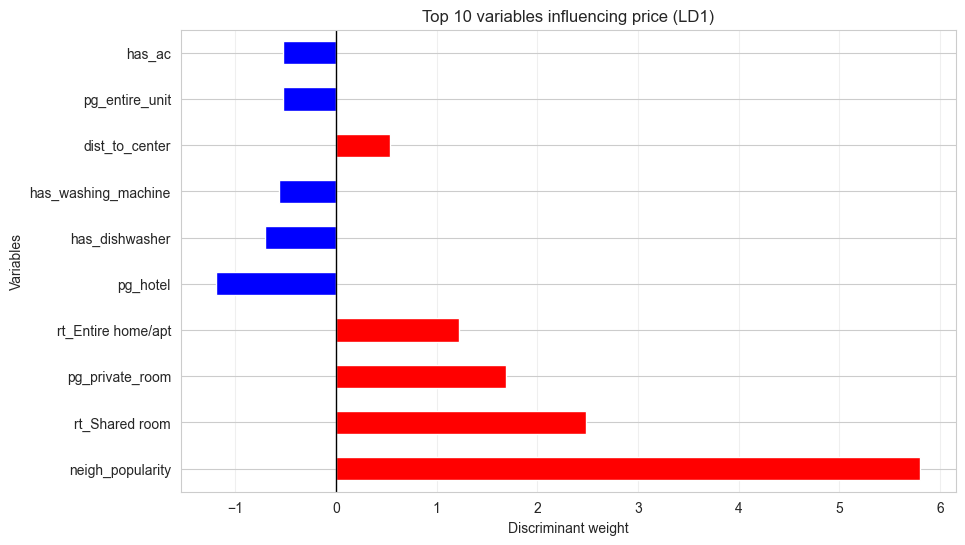

In [ ]:
#LD1 coefficients 
coeffs_ld1 = pd.Series(lda.coef_[0], index=X.columns)

#sorting
top_features = coeffs_ld1.abs().sort_values(ascending=False).head(10) #top 10 features
top_coeffs = coeffs_ld1.loc[top_features.index]

#plot
plt.figure(figsize=(10, 6))
top_coeffs.plot(kind='barh', color=['red' if x > 0 else 'blue' for x in top_coeffs])
plt.title("Top 10 variables influencing price (LD1)")
plt.xlabel("Discriminant weight")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.show()


The analysis demonstrates that the real estate market is structured in a linear ways. The clear visual separation between groups, confirmed by the test data, proves the model's robustness and identifies neighborhood popularity and accommodation type as the primary drivers of value. While the middle market segments show some similarities, luxury properties stand out radically.

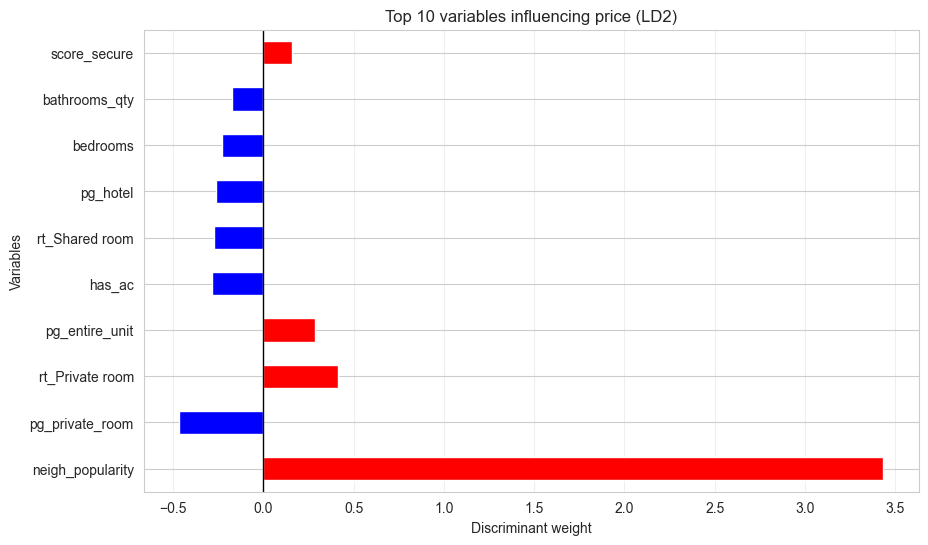

In [ ]:
#LD2 coefficients 
coeffs_ld1 = pd.Series(lda.coef_[1], index=X.columns)

#sorting
top_features = coeffs_ld1.abs().sort_values(ascending=False).head(10)
top_coeffs = coeffs_ld1.loc[top_features.index]

#plot
plt.figure(figsize=(10, 6))
top_coeffs.plot(kind='barh', color=['red' if x > 0 else 'blue' for x in top_coeffs])
plt.title("Top 10 variables influencing price (LD2)")
plt.xlabel("Discriminant weight")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.show()


While the second axis is secondary accounting for only 8.6% of the explained variance it reveals several nuances that complement the geographic dimension. Although neighborhood popularity remains a dominant positive factor, this axis is distinguished by the negative influence of variables related to capacity, such as the number of bedrooms or bathrooms. This suggests that LD2 captures a contrast between highly popular but potentially smaller units and larger properties whose value isn't purely location driven. 

In [ ]:
#LDA coordinates
lda_coords = pd.DataFrame(X_train_lda, columns=[f'LD{i+1}' for i in range(X_train_lda.shape[1])])

#correlations between X_train and the LD axes
structure_matrix = pd.concat([X_train.reset_index(drop=True), lda_coords], axis=1).corr()
final_corr = structure_matrix.loc[X.columns, ['LD1', 'LD2']]

print(final_corr)


                             LD1       LD2
accommodates            0.835905  0.100482
bedrooms                0.791398  0.294905
beds                    0.575632  0.114134
minimum_nights_avg_ntm -0.161780  0.209805
number_of_reviews      -0.115761 -0.089139
dist_to_center         -0.043559  0.302325
bathrooms_qty           0.564270  0.543842
has_ac                  0.314972  0.017732
has_elevator            0.175487 -0.060298
has_dishwasher          0.442307 -0.318149
has_parking             0.107539  0.028797
has_balcony             0.138188 -0.025842
has_washing_machine     0.285634 -0.226646
standing_thermal        0.297028 -0.045701
score_chef_kitchen      0.190397 -0.251545
score_coffee            0.115681 -0.202839
score_wellness          0.304956  0.048095
score_work              0.191816 -0.069765
score_view              0.065100 -0.019255
score_secure           -0.117640 -0.283637
neigh_popularity       -0.198406  0.027439
pg_entire_unit          0.165839 -0.329068
pg_hotel   

The LD1 axis is (unsurprisingly) driven by guest capacity and property size, showing strong correlations for accommodates (0.84) and bedrooms (0.79). This confirms that the primary factor in the Paris real estate pricing is derives from physical space. In contrast, the LD2 axis captures an interesting relatioshinp between management style and configuration. It correlates positively with private rooms and distance from the city center, while showing a negative relationship with entire homes and specific amenities like dishwashers.

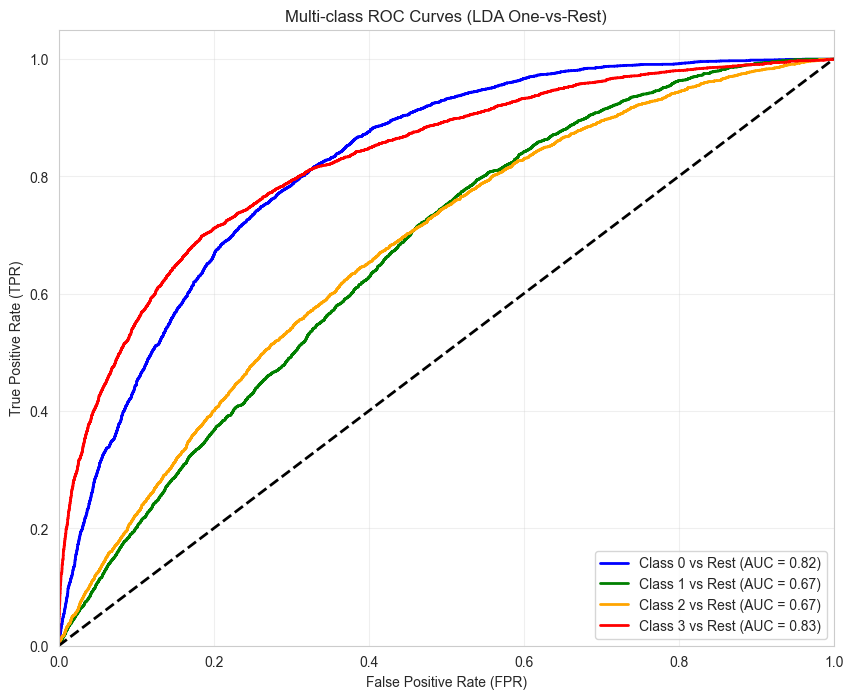

In [ ]:
#ROC curves
#one vs rest per class to evaluate performance by quartile

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#binarize the target 
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

#get predicted probabilities from LDA
y_score = lda.predict_proba(X_test)

#compute and plot curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'Class {i} vs Rest (AUC = {roc_auc:.2f})')

#chart styling
plt.plot([0, 1], [0, 1], 'k--', lw=2) #randomization
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-class ROC Curves (LDA One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


The ROC curves confirm the model’s predictive power, especially for the extreme ends of the market. Classes 0 and 3 display the most convex curves and the highest AUC scores, indicating that the model isolates these categories from the rest of the dataset efficiently. However, Classes 1 and 2 show slightly lower performance with curves closer to the confusion matrix observed earlier. 

CART 

METHOD: CART
Accuracy: 45.70%


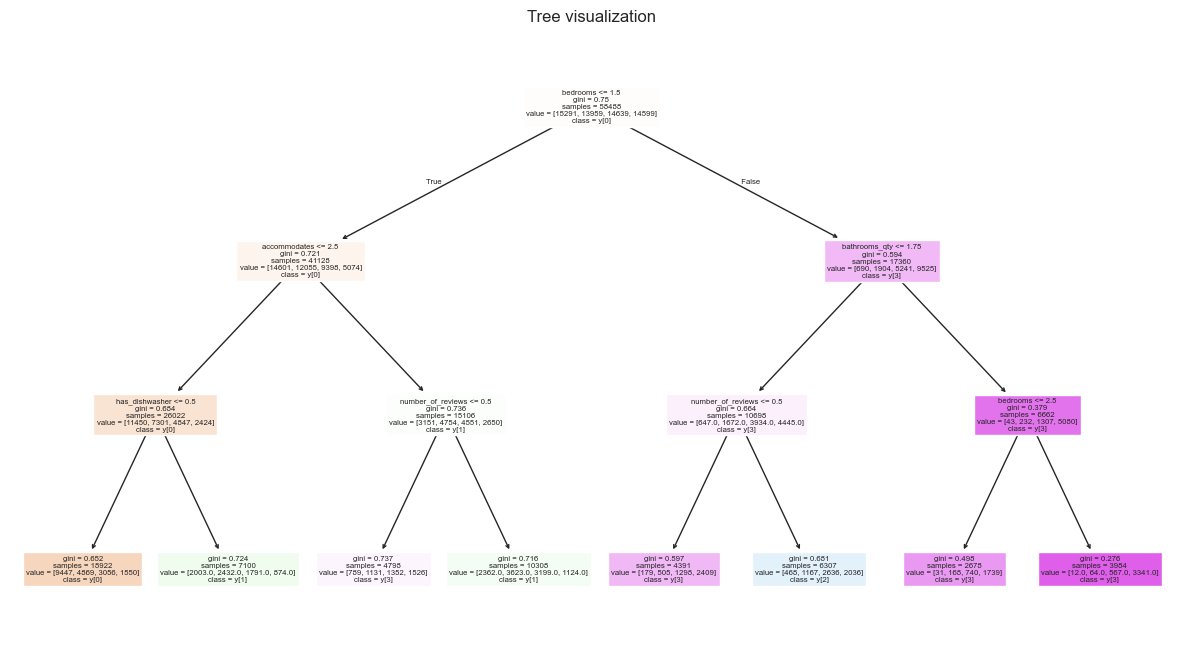

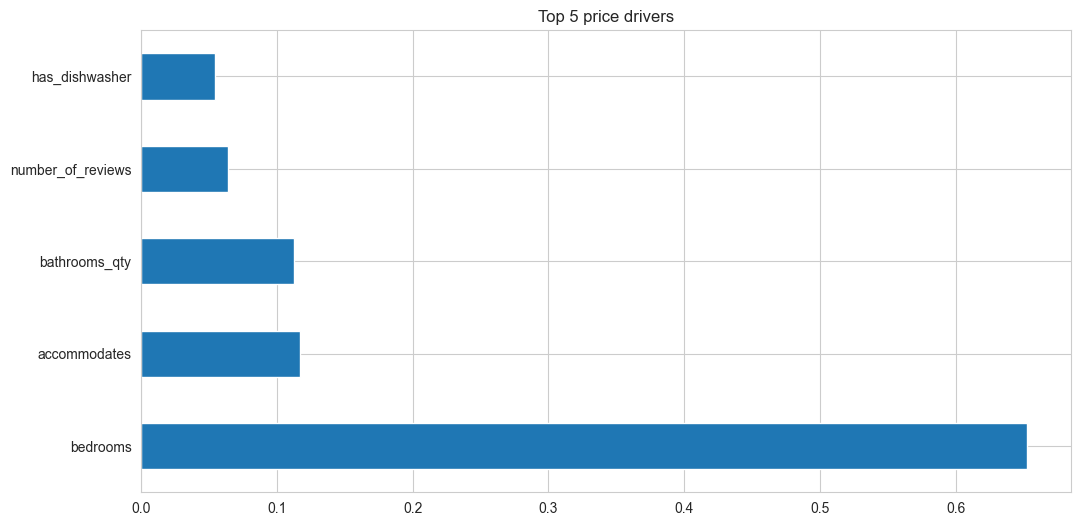

In [ ]:
print("=" * 60)
print("METHOD: CART")
print("=" * 60)

#train 
cart = DecisionTreeClassifier(max_depth=3, random_state=42) #a depth of 3 keeps the tree simple enough to read
cart.fit(X_train, y_train)

#evaluation
y_pred = cart.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

#visualizing the tree
plt.figure(figsize=(15, 8))
plot_tree(cart, feature_names=X.columns, filled=True, class_names=True)
plt.title("Tree visualization")
plt.show()

#feature mportance
importance = pd.Series(cart.feature_importances_, index=X.columns).sort_values(ascending=False)
importance.head(5).plot(kind='barh', title="Top 5 price drivers")
plt.show()

The decision tree visualization reveals a hierarchical logic for price classification. At the top of the tree, the root node based on size or capacity separates the major price categories. As you move down the branches, the model refines its predictions by layering secondary factors like neighborhood popularity or specific amenities.

The feature importance plot highlights the five most influential variables that drive the classification of apartment prices, clearly showing what impacts market value and we can see that physical capacity and geographic aera typically dominate the model's logic as in LDA. It effectively cuts through the noise of the many available features, confirming that while amenities and layout matter, price is mainly driven by the size of the unit and its desirability in the city.

The largest alpha that stays above the cutoff is: 0.00153


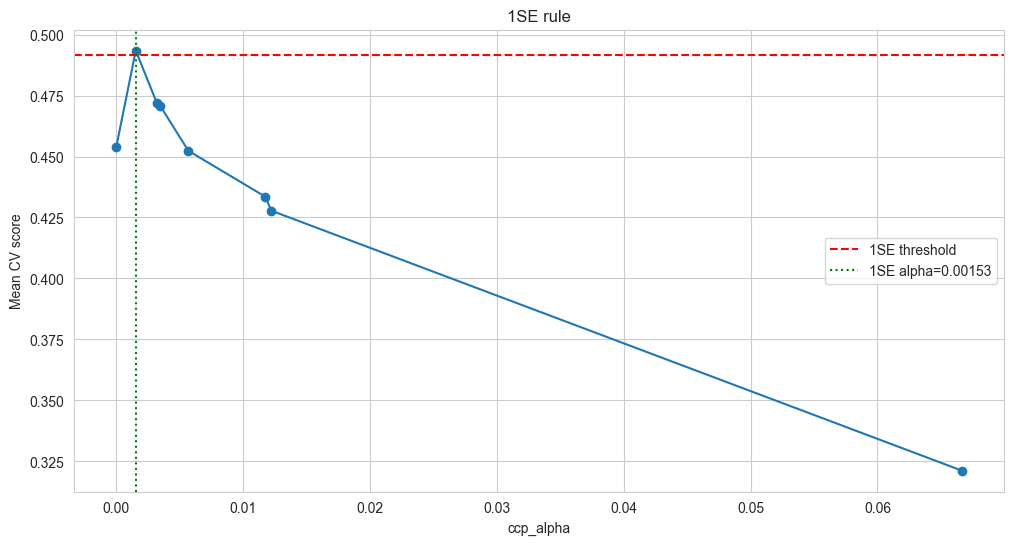

Pruned Tree Accuracy: 48.45%


In [ ]:
#cost complexity path
from sklearn.model_selection import cross_val_score


path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

#finding the best alpha
scores_means = []
scores_stds = []

for alpha in ccp_alphas:
    cv_scores = cross_val_score(DecisionTreeClassifier(ccp_alpha=alpha), X_train, y_train, cv=5)
    scores_means.append(cv_scores.mean())
    scores_stds.append(cv_scores.std())

#1-SE Rule
best_idx = np.argmax(scores_means)
cutoff = scores_means[best_idx] - scores_stds[best_idx]

#largest alpha that stays above the cutoff
optimal_alpha = max([alpha for i, alpha in enumerate(ccp_alphas) if scores_means[i] >= cutoff])
print(f"The largest alpha that stays above the cutoff is: {optimal_alpha:.5f}")

#plot
plt.plot(ccp_alphas, scores_means, marker='o')
plt.axhline(cutoff, color='red', linestyle='--', label='1SE threshold')
plt.axvline(optimal_alpha, color='green', linestyle=':', label=f'1SE alpha={optimal_alpha:.5f}')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean CV score')
plt.title('1SE rule')
plt.legend()
plt.show()

#pruned tree
pruned_cart = DecisionTreeClassifier(ccp_alpha=optimal_alpha, random_state=42)
pruned_cart.fit(X_train, y_train)

print(f"Pruned Tree Accuracy: {pruned_cart.score(X_test, y_test):.2%}")

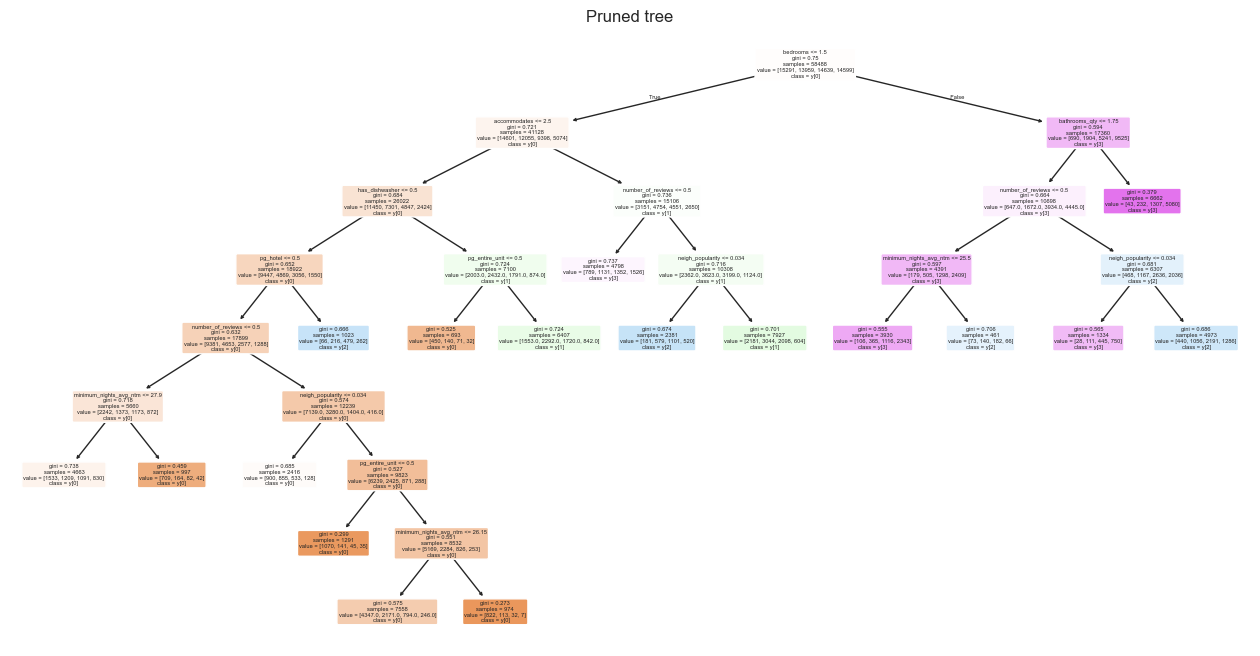

In [ ]:
#pruned tree
plt.figure(figsize=(16, 8))
plot_tree(pruned_cart, 
          feature_names=X.columns, 
          class_names=True, 
          filled=True, 
          rounded=True)

plt.title("Pruned tree")
plt.show()

Final Model Accuracy: 48.45%


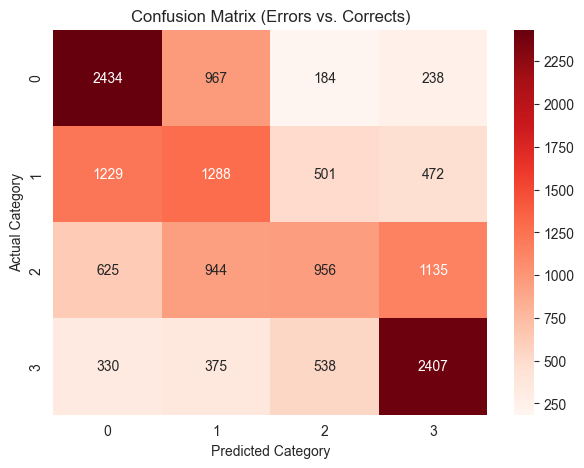

In [ ]:
#pridiction using the pruned model
y_pred = pruned_cart.predict(X_test)

#score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

#Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion matrix")
plt.xlabel("Predicted category")
plt.ylabel("Actual category")
plt.show()

An accuracy of 48.45% indicates that while the model performs better than just random guessing it still struggles to clearly differentiate between all price segments. This performance level suggests that the decision tree is able to capture the characteristics of the extreme categories between the very cheap and the very expensive, but finds the "middle-class" apartments too similar to separate with its algorithm. In a complex market like the Parisian one, where a small studio in a luxury district can cost as much as a large flat in a suburban area, the nearly 50% accuracy confirms that physical features alone can't completely differenciate the market, and the noise within the intermediate market is significant.

The performance of the LDA and the CART algorithm are similar, suggesting that the bottleneck in prediction lies in the data's characteristics rather than the algorithm used. Despite the difference between the two models, they both do a good job at the extremes (Classes 0 and 3) while witnessing a fading performance over the middle ground. This convergence in accuracy confirms that the intermediate price segments in Paris are not cleanly separable by either straight lines or simple decision rules, likely requiring more complex models in order to break the 50% barrier.

In [ ]:
df_model = df_paris.copy()
le = LabelEncoder()
for col in df_model.select_dtypes(include=['object', 'category']).columns:
    df_model[col] = le.fit_transform(df_model[col].astype(str))

drop_cols = [c for c in [ 'price_clean', 'target_class'] if c in df_model.columns]
X = df_model.drop(columns=drop_cols).select_dtypes(include=[np.number])
X = X.fillna(X.median())
y = df_paris['target_class'].values

CLASS_COLORS = ['#2196F3', '#4CAF50', '#FF9800', '#F44336']
CLASS_LABELS = ['Cl.0 – Très bas', 'Cl.1 – Bas-moyen', 'Cl.2 – Haut-moyen', 'Cl.3 – Très haut']
CLASS_SHORT  = ['Cl.0', 'Cl.1', 'Cl.2', 'Cl.3']

print(f"✅ Dataset : {df_paris.shape[0]} observations × {X.shape[1]} features")
print(f"   Distribution de target_class :")
for c in range(4):
    print(f"     Classe {c} : {np.sum(y==c):>5d} obs. ({np.mean(y==c)*100:.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.3, random_state=42, stratify=y
)


✅ Dataset : 73111 observations × 22 features
   Distribution de target_class :
     Classe 0 : 19114 obs. (26.1%)
     Classe 1 : 17449 obs. (23.9%)
     Classe 2 : 18299 obs. (25.0%)
     Classe 3 : 18249 obs. (25.0%)


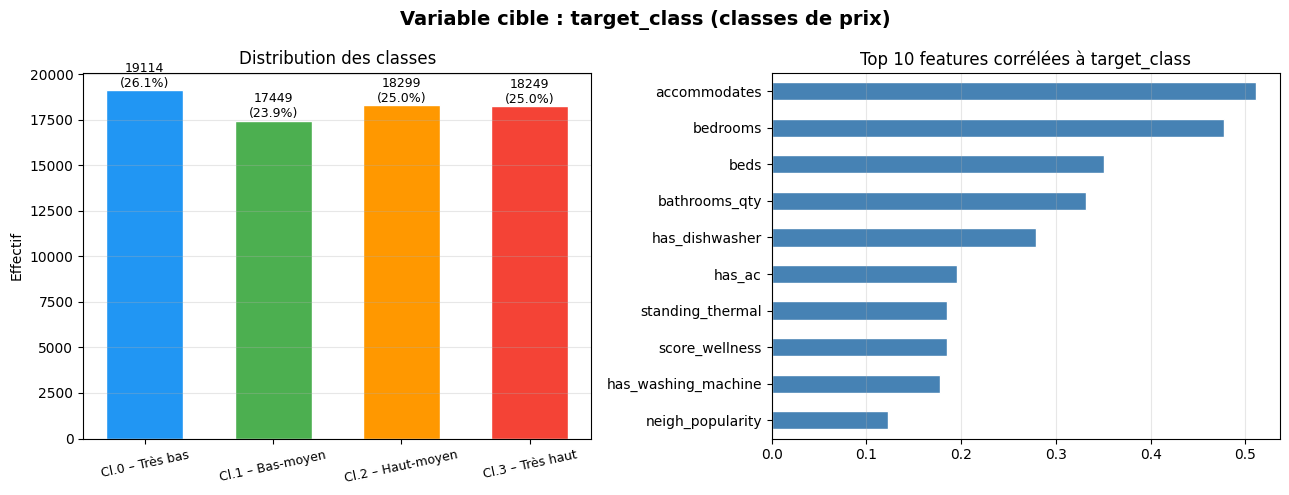

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("Variable cible : target_class (classes de prix)", fontsize=14, fontweight='bold')

counts = pd.Series(y).value_counts().sort_index()
bars = axes[0].bar(range(4), counts.values, color=CLASS_COLORS, edgecolor='white', width=0.6)
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(CLASS_LABELS, rotation=12, fontsize=9)
axes[0].set_ylabel("Effectif")
axes[0].set_title("Distribution des classes")
for bar, v in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 5,
                 f'{v}\n({v/len(y)*100:.1f}%)', ha='center', va='bottom', fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

# Prix moyen par classe (si disponible)
if 'prix' in df_paris.columns:
    prix_by_class = [df_paris[df_paris['target_class'] == c]['prix'].values for c in range(4)]
    bp = axes[1].boxplot(prix_by_class, patch_artist=True, labels=CLASS_SHORT)
    for patch, color in zip(bp['boxes'], CLASS_COLORS):
        patch.set_facecolor(color); patch.set_alpha(0.7)
    axes[1].set_title("Distribution du prix par classe")
    axes[1].set_ylabel("Prix")
    axes[1].grid(axis='y', alpha=0.3)
else:
    # Heatmap des corrélations top features avec target
    corr = pd.DataFrame(X, columns=X.columns if hasattr(X, 'columns') else range(X.shape[1]))
    top_feat = pd.DataFrame(X, columns=df_model.drop(columns=drop_cols)
                            .select_dtypes(include=[np.number]).columns)
    top_feat['target'] = y
    top_corr = top_feat.corr()['target'].drop('target').abs().sort_values(ascending=False).head(10)
    top_corr.plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='white')
    axes[1].set_title("Top 10 features corrélées à target_class")
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


═════════════════════════════════════════════════════════════════
  BOOTSTRAP — Stabilité de target_class
═════════════════════════════════════════════════════════════════
  Moyenne observée : 1.4881
  IC 95% bootstrap : [1.4806 ; 1.4951]

  IC 95% des proportions par classe :
    Classe 0 : 0.261 ± 0.0016  IC95% [0.258 ; 0.264]
    Classe 1 : 0.239 ± 0.0016  IC95% [0.236 ; 0.242]
    Classe 2 : 0.250 ± 0.0016  IC95% [0.247 ; 0.253]
    Classe 3 : 0.250 ± 0.0016  IC95% [0.247 ; 0.253]


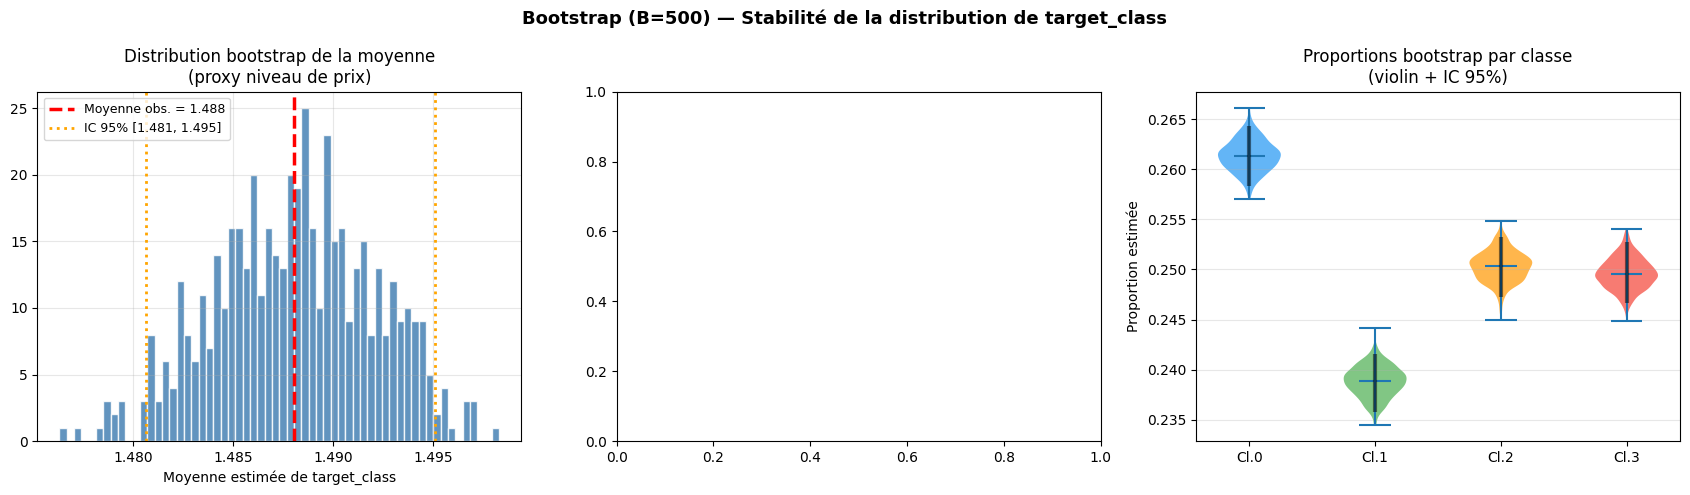

In [ ]:
print("\n" + "═"*65)
print("  BOOTSTRAP — Stabilité de target_class")
print("═"*65)

N_BOOT = 500
bootstrap_props  = {c: [] for c in range(4)}
bootstrap_means  = []

for _ in range(N_BOOT):
    s = resample(y, replace=True, n_samples=len(y))
    bootstrap_means.append(np.mean(s))
    for c in range(4):
        bootstrap_props[c].append(np.mean(s == c))

bootstrap_means = np.array(bootstrap_means)
ci_low  = np.percentile(bootstrap_means, 2.5)
ci_high = np.percentile(bootstrap_means, 97.5)

print(f"  Moyenne observée : {np.mean(y):.4f}")
print(f"  IC 95% bootstrap : [{ci_low:.4f} ; {ci_high:.4f}]")
print(f"\n  IC 95% des proportions par classe :")
for c in range(4):
    p = np.array(bootstrap_props[c])
    print(f"    Classe {c} : {p.mean():.3f} ± {p.std():.4f}  "
          f"IC95% [{np.percentile(p,2.5):.3f} ; {np.percentile(p,97.5):.3f}]")

fig2, axes2 = plt.subplots(1, 3, figsize=(17, 5))
fig2.suptitle(f"Bootstrap (B={N_BOOT}) — Stabilité de la distribution de target_class",
              fontsize=13, fontweight='bold')

# Histogramme de la moyenne bootstrap
axes2[0].hist(bootstrap_means, bins=60, color='steelblue', edgecolor='white', alpha=0.85)
axes2[0].axvline(np.mean(y), color='red',    lw=2.5, linestyle='--',
                 label=f'Moyenne obs. = {np.mean(y):.3f}')
axes2[0].axvline(ci_low,     color='orange', lw=2,   linestyle=':',
                 label=f'IC 95% [{ci_low:.3f}, {ci_high:.3f}]')
axes2[0].axvline(ci_high,    color='orange', lw=2,   linestyle=':')
axes2[0].set_title("Distribution bootstrap de la moyenne\n(proxy niveau de prix)")
axes2[0].set_xlabel("Moyenne estimée de target_class")
axes2[0].legend(fontsize=9)
axes2[0].grid(alpha=0.3)

# Violin plot des proportions par classe
vp_data = [bootstrap_props[c] for c in range(4)]
parts = axes2[2].violinplot(vp_data, positions=range(4), showmedians=True,
                            showextrema=True)
for i, (body, color) in enumerate(zip(parts['bodies'], CLASS_COLORS)):
    body.set_facecolor(color); body.set_alpha(0.7)
# IC 95%
for c in range(4):
    p = np.array(bootstrap_props[c])
    axes2[2].vlines(c, np.percentile(p, 2.5), np.percentile(p, 97.5),
                    color='black', lw=3, alpha=0.5)
axes2[2].set_xticks(range(4))
axes2[2].set_xticklabels(CLASS_SHORT)
axes2[2].set_title("Proportions bootstrap par classe\n(violin + IC 95%)")
axes2[2].set_ylabel("Proportion estimée")
axes2[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



═════════════════════════════════════════════════════════════════
  BAGGING — Convergence OOB selon B
═════════════════════════════════════════════════════════════════
  CART seul (erreur test) : 0.5462
  OOB minimale : 0.4598  (B=295)


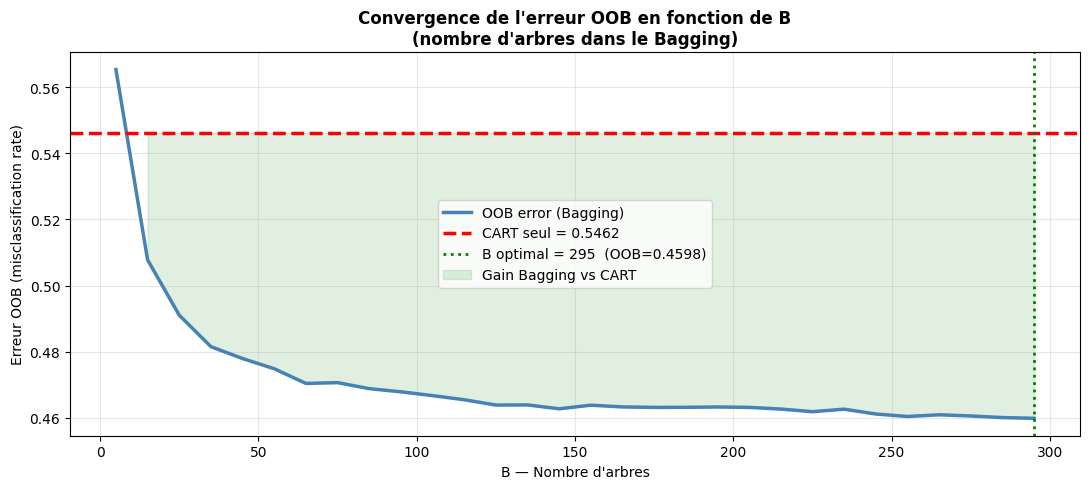

In [ ]:
print("\n" + "═"*65)
print("  BAGGING — Convergence OOB selon B")
print("═"*65)

B_range  = list(range(5, 301, 10))
oob_errs = []

for b_val in B_range:
    bag_tmp = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=b_val,
        bootstrap=True, oob_score=True,
        random_state=42, n_jobs=-1
    )
    bag_tmp.fit(X_train, y_train)
    oob_errs.append(1 - bag_tmp.oob_score_)

# Erreur de test CART seul
cart_ref = DecisionTreeClassifier(random_state=42)
cart_ref.fit(X_train, y_train)
err_cart_ref = 1 - accuracy_score(y_test, cart_ref.predict(X_test))
print(f"  CART seul (erreur test) : {err_cart_ref:.4f}")

# B optimal
best_B   = B_range[np.argmin(oob_errs)]
best_oob = min(oob_errs)
print(f"  OOB minimale : {best_oob:.4f}  (B={best_B})")

fig3, ax3 = plt.subplots(figsize=(11, 5))
ax3.plot(B_range, oob_errs, color='steelblue', lw=2.5, label='OOB error (Bagging)')
ax3.axhline(err_cart_ref, color='red', linestyle='--', lw=2.5,
            label=f'CART seul = {err_cart_ref:.4f}')
ax3.axvline(best_B, color='green', linestyle=':', lw=2,
            label=f'B optimal = {best_B}  (OOB={best_oob:.4f})')
ax3.fill_between(B_range, oob_errs, err_cart_ref,
                 where=[o < err_cart_ref for o in oob_errs],
                 alpha=0.12, color='green', label='Gain Bagging vs CART')
ax3.set_title("Convergence de l'erreur OOB en fonction de B\n(nombre d'arbres dans le Bagging)",
              fontsize=12, fontweight='bold')
ax3.set_xlabel("B — Nombre d'arbres")
ax3.set_ylabel("Erreur OOB (misclassification rate)")
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)
plt.tight_layout()
plt.show()

  CART    : 0.5478 ± 0.0031
  Bagging : 0.4649 ± 0.0029
  Bagging < CART dans 50/50 simulations


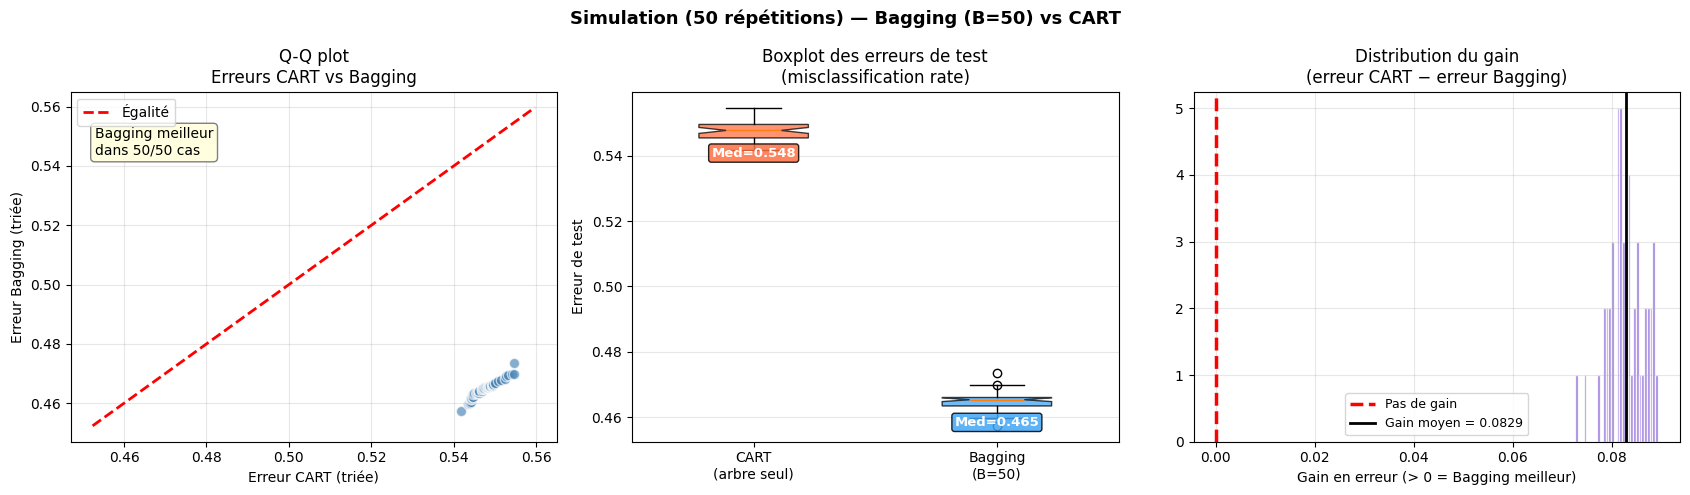

In [ ]:
N_SIM = 50
B_SIM = 50
errors_cart, errors_bag = [], []

for sim in range(N_SIM):
    Xtr, Xte, ytr, yte = train_test_split(
        X.values, y, test_size=0.3, random_state=sim, stratify=y
    )
    c = DecisionTreeClassifier(random_state=sim)
    c.fit(Xtr, ytr)
    errors_cart.append(1 - accuracy_score(yte, c.predict(Xte)))

    b = BaggingClassifier(estimator=DecisionTreeClassifier(),
                          n_estimators=B_SIM, bootstrap=True,
                          random_state=sim, n_jobs=-1)
    b.fit(Xtr, ytr)
    errors_bag.append(1 - accuracy_score(yte, b.predict(Xte)))

errors_cart = np.array(errors_cart)
errors_bag  = np.array(errors_bag)

print(f"  CART    : {errors_cart.mean():.4f} ± {errors_cart.std():.4f}")
print(f"  Bagging : {errors_bag.mean():.4f} ± {errors_bag.std():.4f}")
print(f"  Bagging < CART dans {np.sum(errors_bag < errors_cart)}/{N_SIM} simulations")

fig4, axes4 = plt.subplots(1, 3, figsize=(17, 5))
fig4.suptitle(f"Simulation ({N_SIM} répétitions) — Bagging (B={B_SIM}) vs CART",
              fontsize=13, fontweight='bold')

# Q-Q plot
axes4[0].scatter(np.sort(errors_cart), np.sort(errors_bag),
                 color='steelblue', alpha=0.65, s=55, edgecolors='white')
lims = [min(errors_cart.min(), errors_bag.min()) - 0.005,
        max(errors_cart.max(), errors_bag.max()) + 0.005]
axes4[0].plot(lims, lims, 'r--', lw=2, label='Égalité')
axes4[0].set_title("Q-Q plot\nErreurs CART vs Bagging")
axes4[0].set_xlabel("Erreur CART (triée)")
axes4[0].set_ylabel("Erreur Bagging (triée)")
axes4[0].legend()
axes4[0].grid(alpha=0.3)
n_better = np.sum(errors_bag < errors_cart)
axes4[0].annotate(f"Bagging meilleur\ndans {n_better}/{N_SIM} cas",
                  xy=(0.05, 0.82), xycoords='axes fraction', fontsize=10,
                  bbox=dict(boxstyle='round', fc='lightyellow', ec='gray'))

# Boxplot
bp4 = axes4[1].boxplot([errors_cart, errors_bag],
                       labels=['CART\n(arbre seul)', f'Bagging\n(B={B_SIM})'],
                       patch_artist=True, widths=0.45, notch=True)
bp4['boxes'][0].set_facecolor('#FF7043'); bp4['boxes'][0].set_alpha(0.75)
bp4['boxes'][1].set_facecolor('#42A5F5'); bp4['boxes'][1].set_alpha(0.75)
axes4[1].set_title("Boxplot des erreurs de test\n(misclassification rate)")
axes4[1].set_ylabel("Erreur de test")
for i, (errs, col) in enumerate(zip([errors_cart, errors_bag], ['#FF7043', '#42A5F5']), 1):
    axes4[1].text(i, np.median(errs) - 0.008,
                  f'Med={np.median(errs):.3f}', ha='center', fontsize=9.5,
                  fontweight='bold', color='white',
                  bbox=dict(boxstyle='round,pad=0.2', fc=col, alpha=0.85))
axes4[1].grid(axis='y', alpha=0.3)

# Distribution des différences
diffs = errors_cart - errors_bag
axes4[2].hist(diffs, bins=30, color='mediumpurple', edgecolor='white', alpha=0.85)
axes4[2].axvline(0,             color='red',    lw=2.5, linestyle='--', label='Pas de gain')
axes4[2].axvline(diffs.mean(),  color='black',  lw=2,   linestyle='-',
                 label=f'Gain moyen = {diffs.mean():.4f}')
axes4[2].set_title("Distribution du gain\n(erreur CART − erreur Bagging)")
axes4[2].set_xlabel("Gain en erreur (> 0 = Bagging meilleur)")
axes4[2].legend(fontsize=9)
axes4[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


═════════════════════════════════════════════════════════════════
  ESTIMATEURS DE PRÉCISION — Test / CV / OOB
═════════════════════════════════════════════════════════════════
  Erreur test (70/30)   : 0.4597
  5-fold CV             : 0.4585 ± 0.0030
  10-fold CV            : 0.4558 ± 0.0044
  OOB error             : 0.4580


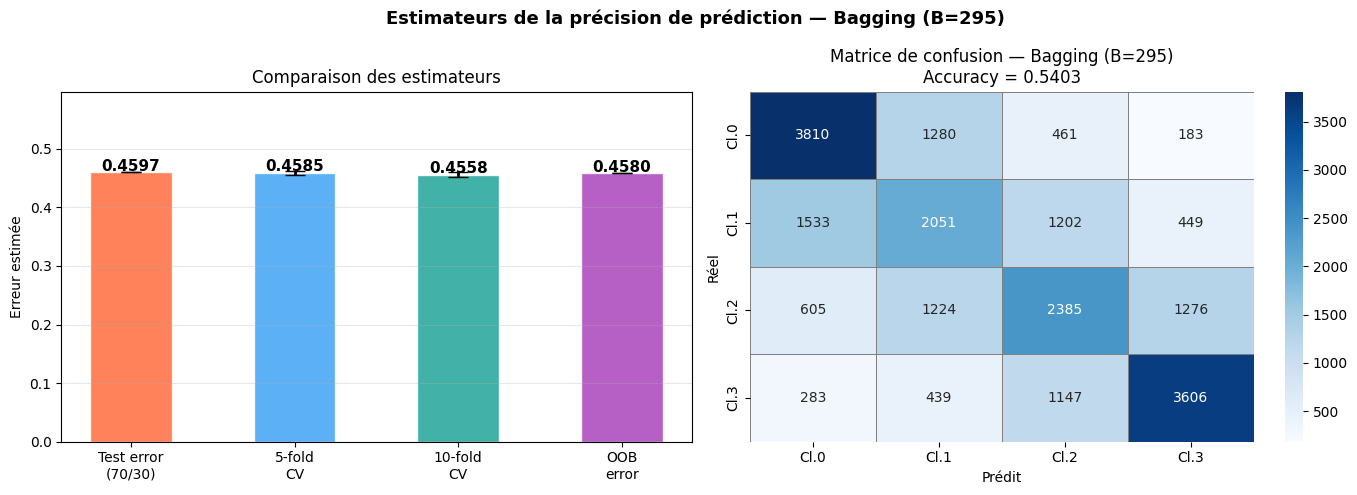

In [ ]:
print("\n" + "═"*65)
print("  ESTIMATEURS DE PRÉCISION — Test / CV / OOB")
print("═"*65)

B_FINAL = best_B

# Test error
bag_test = BaggingClassifier(estimator=DecisionTreeClassifier(),
                             n_estimators=B_FINAL, bootstrap=True,
                             random_state=42, n_jobs=-1)
bag_test.fit(X_train, y_train)
err_test = 1 - accuracy_score(y_test, bag_test.predict(X_test))

# CV 5 et 10 fold
cv_res = {}
for k in [5, 10]:
    bag_cv = BaggingClassifier(estimator=DecisionTreeClassifier(),
                               n_estimators=B_FINAL, bootstrap=True, random_state=42)
    scores = cross_val_score(bag_cv, X.values, y, cv=StratifiedKFold(k, shuffle=True, random_state=42),
                             scoring='accuracy', n_jobs=-1)
    cv_res[k] = 1 - scores

# OOB
bag_oob = BaggingClassifier(estimator=DecisionTreeClassifier(),
                            n_estimators=B_FINAL, bootstrap=True,
                            oob_score=True, random_state=42, n_jobs=-1)
bag_oob.fit(X.values, y)
err_oob = 1 - bag_oob.oob_score_

print(f"  Erreur test (70/30)   : {err_test:.4f}")
print(f"  5-fold CV             : {cv_res[5].mean():.4f} ± {cv_res[5].std():.4f}")
print(f"  10-fold CV            : {cv_res[10].mean():.4f} ± {cv_res[10].std():.4f}")
print(f"  OOB error             : {err_oob:.4f}")

labels5  = ['Test error\n(70/30)', '5-fold\nCV', '10-fold\nCV', 'OOB\nerror']
means5   = [err_test, cv_res[5].mean(), cv_res[10].mean(), err_oob]
stds5    = [0, cv_res[5].std(), cv_res[10].std(), 0]
colors5  = ['#FF7043', '#42A5F5', '#26A69A', '#AB47BC']

fig5, axes5 = plt.subplots(1, 2, figsize=(14, 5))
fig5.suptitle(f"Estimateurs de la précision de prédiction — Bagging (B={B_FINAL})",
              fontsize=13, fontweight='bold')

bars5 = axes5[0].bar(labels5, means5, color=colors5, edgecolor='white',
                     width=0.5, alpha=0.87)
axes5[0].errorbar(range(4), means5, yerr=stds5,
                  fmt='none', color='black', capsize=7, lw=2)
for bar, val in zip(bars5, means5):
    axes5[0].text(bar.get_x() + bar.get_width()/2, val + 0.003,
                  f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')
axes5[0].set_ylabel("Erreur estimée")
axes5[0].set_title("Comparaison des estimateurs")
axes5[0].set_ylim(0, max(means5) * 1.3)
axes5[0].grid(axis='y', alpha=0.3)

# Matrice de confusion du meilleur modèle
y_pred_final = bag_test.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes5[1],
            xticklabels=CLASS_SHORT, yticklabels=CLASS_SHORT,
            linewidths=0.5, linecolor='gray')
axes5[1].set_title(f"Matrice de confusion — Bagging (B={B_FINAL})\n"
                   f"Accuracy = {1-err_test:.4f}")
axes5[1].set_xlabel("Prédit")
axes5[1].set_ylabel("Réel")

plt.tight_layout()
plt.show()

Random tree forest

Grid search to find the best hyperparameters using cross-validation

In [ ]:
# hyperparameters to explore
param_grid = {
    # sqrt(p) is the standard choice, log2 is more conservative
    'max_features': ['sqrt', 'log2'], 

    # more trees reduces variance, but gains plateau at some point
    'n_estimators': [100, 300], 

    # deeper trees risk memorising the training data
    'max_depth': [10, 15, 20, 30],

    # minimum samples per leaf, higher values smooth out variance
    'min_samples_leaf': [2, 5, 10]
}


In [ ]:
def run_custom_grid_search(X, y, scoring_metric='accuracy'):
    print(f"\n Running Grid Search (metric: {scoring_metric})...")
    
    rf = RandomForestClassifier(random_state=123, n_jobs=-1)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,                  # 5-Fold Cross Validation
        scoring=scoring_metric,
        return_train_score=True, # to check for overfitting
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    cols_interest = [
        'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_n_estimators',
        'mean_test_score', 'std_test_score',  # Validation performance (Variance)
        'mean_train_score'                    # Training performance (Bias)
    ]
    summary = results[cols_interest].copy()
    
    # Rename for readability
    summary.rename(columns={
        'mean_test_score': 'Mean_CV_Score',
        'std_test_score': 'CV_Std (Variance)',
        'mean_train_score': 'Train_Score (Overfit?)'
    }, inplace=True)
    
    # Sort by best validation score
    summary = summary.sort_values(by='Mean_CV_Score', ascending=False)
    
    return grid_search.best_estimator_, summary

Grid search over accuracy and F1-macro

In [ ]:
# change the flag to True if you want to rerun the 
# takes between 8 and 20 mins
RUN_GRID_SEARCH = False
if RUN_GRID_SEARCH:    
# grid search on accuracy
    best_model_acc, res_acc = run_custom_grid_search(X_train, y_train, scoring_metric='accuracy')

    print("\n Top 5 configurations (accuracy):")
    # check the top 5 to manually pick the best trade-off
    print(res_acc.head(5).to_string(index=False))



 Lancement de la Grid Search (Métrique : accuracy)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/p


 top 5 configurations (accuracy) :
 param_max_depth param_max_features  param_min_samples_leaf  param_n_estimators  Score_Moyen_CV  Ecart_Type_CV (Variance)  Score_Train (Overfit?)
              20               log2                       2                 300        0.560081                  0.006387                0.846028
              20               sqrt                       2                 300        0.559910                  0.005100                0.861848
              20               sqrt                       5                 300        0.559841                  0.005041                0.732539
              20               log2                       5                 300        0.559140                  0.006273                0.716938
              30               sqrt                       5                 300        0.559123                  0.004630                0.753522


5 folds for the CV — with 73k rows that's roughly 14k samples per fold, solid enough for reliable estimates without running for hours.

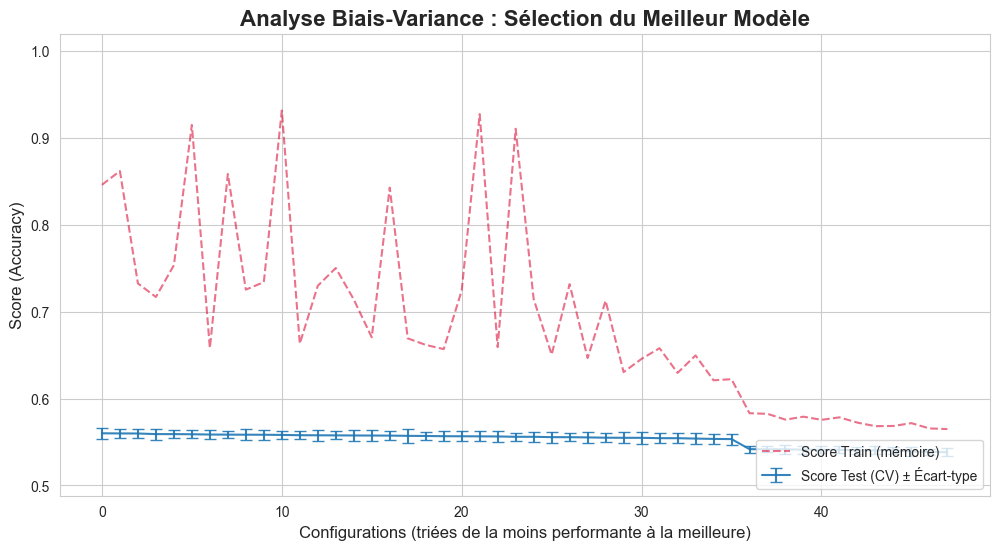

In [ ]:
# Re-run this if you relaunch the grid search to get up-to-date results

plt.figure(figsize=(12, 6))

x_axis = range(len(res_acc))

# mean validation score with error bars 
plt.errorbar(
    x=x_axis,
    y=res_acc['Mean_CV_Score'],
    yerr=res_acc['CV_Std (Variance)'],
    elinewidth=1.5,
    capsize=4,
    alpha=0.9,
    label='Test Score (CV) ± Std'
)

# training score to spot overfitting
plt.plot(
    x_axis,
    res_acc['Train_Score (Overfit?)'],
    color='crimson',
    linestyle='--',
    alpha=0.6,
    label='Train Score (memorisation)'
)

plt.title('Bias-Variance Analysis: Model Selection', fontsize=16, fontweight='bold')
plt.xlabel('Configurations (sorted from worst to best)', fontsize=12)
plt.ylabel('Score (Accuracy)', fontsize=12)
plt.legend(loc='lower right', frameon=True)

min_y = res_acc['Mean_CV_Score'].min() - 0.05
plt.ylim(min_y, 1.02)

plt.show()


### Bias-variance trade-off

On the left of the chart, configs with very deep trees memorise the training set (red score near 90%) but stall around 0.56 in validation — the gap speaks for itself.

Towards the right, the training score comes down (~73%) while the test score stays stable. that's the zone we care about: less memorisation, better generalisation.

Also running on F1-macro to check if it changes anything — in theory it shouldn't, the classes are balanced by construction. No need to re-run this!

In [ ]:
# change the flag to True if you want to rerun the 
# takes between 8 and 20 mins
RUN_GRID_SEARCH = False
if RUN_GRID_SEARCH:    
    # TEST ON F1-MACRO
    best_model_f1, res_f1 = run_custom_grid_search(X_train, y_train, scoring_metric='f1_macro')

    print("\n TOP 5 CONFIGURATIONS (F1-MACRO):")
    print(res_f1.head(5).to_string(index=False))


 Lancement de la Grid Search (Métrique : f1_macro)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/p


 TOP 5 CONFIGURATIONS (F1-MACRO) :
 param_max_depth param_max_features  param_min_samples_leaf  param_n_estimators  Score_Moyen_CV  Ecart_Type_CV (Variance)  Score_Train (Overfit?)
              20               sqrt                       2                 300        0.550632                  0.005294                0.861492
              20               log2                       2                 300        0.550313                  0.006540                0.845385
              20               sqrt                       5                 300        0.549906                  0.005348                0.728854
              30               log2                       2                 300        0.549513                  0.004850                0.915007
              30               sqrt                       2                 300        0.549289                  0.004960                0.931642


The best model by F1-macro matches the 2nd-best by accuracy, but with noticeably lower variance. That's the one we keep.

Training the optimal model

In [ ]:
# Hardcoded optimal parameters so we don't have to rerun the grid search
opti_max_depth = 20
opti_param_max_features = 'sqrt'
opti_param_min_samples_leaf = 5
opti_param_n_estimators = 300

In [ ]:
rf_opti = RandomForestClassifier(
    n_estimators=opti_param_n_estimators,
    max_depth=opti_max_depth,
    min_samples_leaf=opti_param_min_samples_leaf,
    max_features=opti_param_max_features,
    random_state=123,
    n_jobs=-2       # leave one cpu core free
)

In [13]:
rf_opti.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=300,
                       n_jobs=-2, random_state=123)

Simplified example of a prediction on a test listing

Results of the optimal model on the test set

In [ ]:
y_pred = rf_opti.predict(X_test)
# Scores
acc = accuracy_score(y_test, y_pred)
f1_macro = classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score']
print(f"\n FINAL ACCURACY: {acc:.2%}")
print(f" F1-MACRO: {f1_macro:.2%}")


 PRÉCISION FINALE (Accuracy) : 56.73%
 F1-MACRO : 55.75%


In [ ]:
target_names = ['Budget (0)', 'Standard (1)', 'Premium (2)', 'Luxury (3)']
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=target_names))


--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

     Éco (0)       0.61      0.73      0.66      3823
Standard (1)       0.44      0.39      0.42      3490
 Premium (2)       0.50      0.43      0.46      3660
    Luxe (3)       0.67      0.70      0.69      3650

    accuracy                           0.57     14623
   macro avg       0.56      0.56      0.56     14623
weighted avg       0.56      0.57      0.56     14623



The OOB score is the forest's internal estimate of its own performance: each tree is evaluated on the samples it never saw during training. If it's close to the test score, that's a good sign

In [ ]:
print("\n=== OOB validation (out-of-bag) ===")

# same params as rf_opti, just with oob_score=True added
rf_oob = RandomForestClassifier(
    n_estimators=opti_param_n_estimators,
    max_depth=opti_max_depth,
    min_samples_leaf=opti_param_min_samples_leaf,
    max_features=opti_param_max_features,
    oob_score=True,
    random_state=123
)

rf_oob.fit(X_train, y_train)

oob_acc = rf_oob.oob_score_
test_acc = accuracy_score(y_test, rf_oob.predict(X_test))

print(f" OOB (internal estimate) : {oob_acc:.4f}")
print(f" Test score (real validation) : {test_acc:.4f}")

if abs(oob_acc - test_acc) < 0.02:
    print("Both scores are very close — the model generalises well.")



=== validation OOB (out-of-bag) ===
 OOB (estimation interne) : 0.5596
 score test (validation réelle) : 0.5673
les deux scores sont très proches, le modèle généralise bien.


OOB Validation

The OOB score (0.5599) is very close to the test set accuracy (0.57). This confirms the results don't depend on a lucky train/test split — the model is stable.

Confusion Matrix

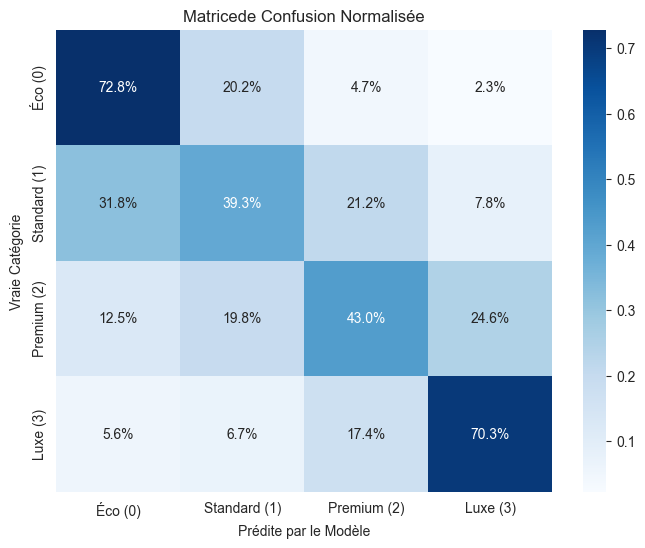

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

# Normalise to get percentages
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, fmt='.1%', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('True Category')
plt.xlabel('Predicted by the Model')
plt.title('Normalised Confusion Matrix')
plt.show()

### Reading the confusion matrix

The model does well at the extremes: **Budget** at 72.9% and **Luxury** at 70.1%. These two categories have fairly distinct profiles, so the model picks them up without too much trouble.

Where it struggles is between **Standard** and **Premium** (around 40% each). The difference between these classes often comes down to visual cues — decor, natural light, overall feel — which tabular data doesn't really capture.

Misclassifications stay reasonable: the model almost always errs by at most one class. Severe errors (Budget confused with Luxury or vice versa) account for less than 6% of cases.

INTERPRETATION (FEATURE IMPORTANCE)

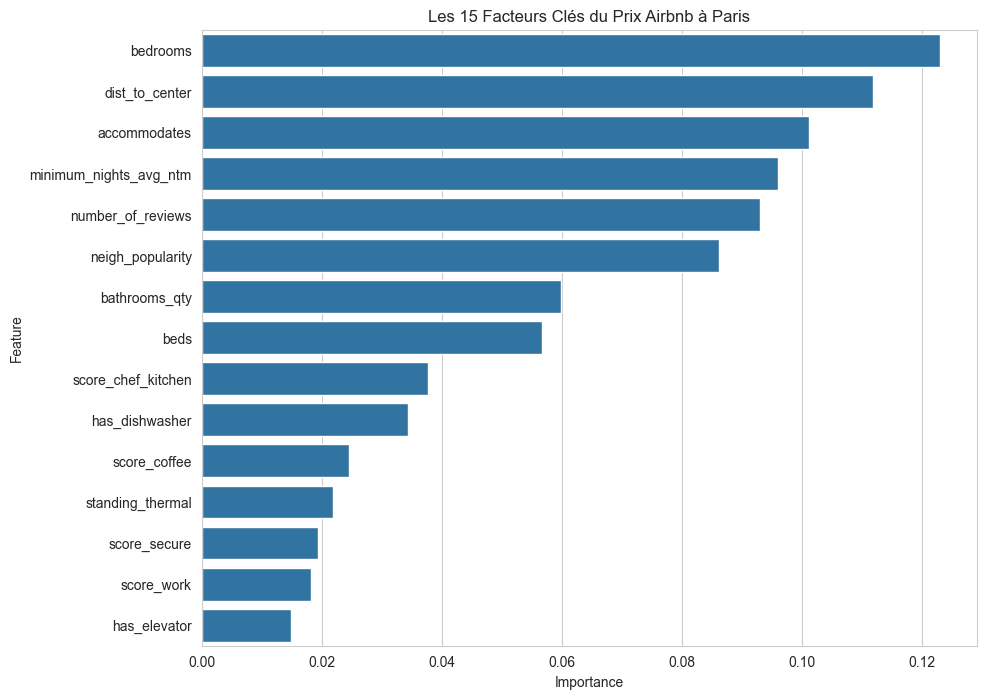

In [ ]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_opti.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title('Top 15 Factors Driving Airbnb Prices in Paris')
plt.show()

Feature importance measures each variable's cumulative contribution to reducing Gini impurity across all trees. The more effectively a variable separates classes, the higher its score.

### What drives price in Paris

Unsurprisingly, **listing size** dominates: bedrooms, accommodates and beds are all at the top. **dist_to_center** comes right after — the Parisian real estate logic is well captured.

This chart ranks variables by their impact on the model's decisions:

1.  **Apartment structure:** **bedrooms** is the top predictor, closely followed by **accommodates** (capacity) and **beds**. Size is the main driver of price by a wide margin.
2.  **Location:** **dist_to_center** (distance to Notre-Dame) is the second most influential feature, confirming the classic Parisian real estate pattern.
3.  **Host profile:** **minimum_nights** and **number_of_reviews** rank surprisingly high. This suggests that professional hosts — who require longer stays and accumulate reviews — have pricing strategies that differ meaningfully from occasional renters.
4.  **Amenities:** Multiple bathrooms (**bathrooms_qty**) and a well-equipped kitchen (**score_chef_kitchen**) are the most discriminating comfort indicators.

### Performance summary

57% accuracy on 4 balanced classes — given that random guessing would give 25%, the model is clearly learning something meaningful.

The F1-macro at 0.56 confirms we're not gaming the metric by favouring one class: performance is fairly consistent across all four. The extreme classes (Budget and Luxury) are predicted more reliably; the middle ones are harder to tell apart without visual data.

Overall the model is usable for filtering price ranges, even if you shouldn't expect pinpoint precision between Standard and Premium.